In [ ]:
# Import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, cross_val_score 

import time



In [2]:


'''
Using the Visegard group data, which consists of quarterly and yearly financial reports of the v4 companies.

Machine learning problem: Regression -- Can we predict the profitability ratio 
for next quarter, as measured by EBITDA */total assets, of a V4 company Given this year's
quarterly data?

There are 450 companies that are uniquely identified in each quarterly/yearly report/file.
'''

# Link to data specs: https://archive.ics.uci.edu/dataset/830/visegrad+group+companies+data-2

# We load in quarterly data from 2017 and Q1 of 2018 and concatenate into a meta-dataframe to make a time series dataset. 

# 2017 Quarterly Data
quarters = ["Q1", "Q2", "Q3", "Q4"]

meta_df = pd.DataFrame()
for i in quarters:
    df = pd.read_csv('/Users/dy/Desktop/DATA1030/DATA1030-Fall2024/term_project/data/2017 %s.csv' % i)
    df['yr'] = 2017
    df['quarter'] = i
    print(df.shape)
    meta_df = pd.concat([meta_df,df])



print(meta_df.shape)

# 2018 Q1 data
df = pd.read_csv('/Users/dy/Desktop/DATA1030/DATA1030-Fall2024/term_project/data/2018 Q1.csv')
df['yr'] = 2018
df['quarter'] = "Q1"
meta_df = pd.concat([meta_df, df])

print(meta_df.shape)
print(meta_df.columns)



(450, 87)
(450, 87)
(450, 87)
(450, 87)
(1800, 87)
(2250, 87)
Index(['Num', 'Country', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29',
       'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39',
       'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49',
       'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59',
       'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69',
       'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79',
       'X80', 'X81', 'X82', 'S', 'yr', 'quarter'],
      dtype='object')


# Prepping Data for EDA/Preprocessing

We need to:
- Replace missing values ("m") with NaN to be detectable as a missing value.
- Replace 0 with 1e-14 to allow for logarithmic scaling of X39. 
- Cast all columns as their appropriate types.

In [3]:
## Prepping data for EDA
str = str
# Missing values are "m". We replace the missing values with NaN 
df = meta_df
df = df.replace("m", np.nan) # to make it detectable with .isnan

# Replace 0 with 0.00000000000001 to avoid dividing by 0 in log
df = df.replace(0, 0.00000000000001)
# Replace Czech Republic str
df =  df.replace("'Czech Republic'", "Czech Republic")
print(df.info())

#Casting each column as its respective type
for col_name in df.columns.tolist():
    print(col_name)
    if col_name == 'S' or col_name == 'Num' or col_name == "yr": 
        df[col_name] = df[col_name].astype(int)
    elif col_name == 'Country' or col_name == 'quarter': df[col_name] = df[col_name].astype(str)
    else: df[col_name] = df[col_name].astype(float)


df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2250 entries, 0 to 449
Data columns (total 87 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Num      2250 non-null   int64 
 1   Country  2250 non-null   object
 2   X1       1939 non-null   object
 3   X2       1940 non-null   object
 4   X3       1935 non-null   object
 5   X4       1934 non-null   object
 6   X5       1940 non-null   object
 7   X6       1940 non-null   object
 8   X7       1939 non-null   object
 9   X8       1940 non-null   object
 10  X9       1940 non-null   object
 11  X10      1939 non-null   object
 12  X11      1939 non-null   object
 13  X12      1858 non-null   object
 14  X13      1945 non-null   object
 15  X14      1934 non-null   object
 16  X15      1939 non-null   object
 17  X16      1938 non-null   object
 18  X17      1863 non-null   object
 19  X18      1939 non-null   object
 20  X19      1862 non-null   object
 21  X20      1940 non-null   object
 22  X21   

,Num,Country,X1,X2,X3,X4,X5,X6,X7,X8,...,X76,X77,X78,X79,X80,X81,X82,S,yr,quarter
0,10,Hungary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2017,Q1
1,22,Poland,0.00,0.49,0.06,1.31,0.05,0.00,1.03,0.17,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1,2017,Q1
2,27,Hungary,0.01,0.77,-0.04,0.89,0.00,0.01,0.29,0.30,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1,2017,Q1
3,73,Poland,-0.02,0.58,0.15,1.29,0.22,-0.02,0.71,0.06,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1,2017,Q1
4,74,Poland,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2017,Q1


In [4]:
# Outputting the types of columns/features

print("Number of rows in the dataframe:", df.shape[0])
print("Number of columns in the dataframe:", df.shape[1])

# Column names and types
col_names = []
for col in df.columns:
    col_names.append(col)
#print(col_names)

row = df.loc[0]
types = df.dtypes

output = []
for i in range(len(col_names)):
    output.append((col_names[i],str(types[i])))

print("Types:", output)

#print(df.info())

#print("We can drop the 'Num' column for ML training.")

#df = df.drop('Num', axis = 1)

# drop NAs in X39
#df = df.dropna(subset=['X39'])

print(df.info())

Number of rows in the dataframe: 2250
Number of columns in the dataframe: 87
Types: [('Num', 'int64'), ('Country', 'object'), ('X1', 'float64'), ('X2', 'float64'), ('X3', 'float64'), ('X4', 'float64'), ('X5', 'float64'), ('X6', 'float64'), ('X7', 'float64'), ('X8', 'float64'), ('X9', 'float64'), ('X10', 'float64'), ('X11', 'float64'), ('X12', 'float64'), ('X13', 'float64'), ('X14', 'float64'), ('X15', 'float64'), ('X16', 'float64'), ('X17', 'float64'), ('X18', 'float64'), ('X19', 'float64'), ('X20', 'float64'), ('X21', 'float64'), ('X22', 'float64'), ('X23', 'float64'), ('X24', 'float64'), ('X25', 'float64'), ('X26', 'float64'), ('X27', 'float64'), ('X28', 'float64'), ('X29', 'float64'), ('X30', 'float64'), ('X31', 'float64'), ('X32', 'float64'), ('X33', 'float64'), ('X34', 'float64'), ('X35', 'float64'), ('X36', 'float64'), ('X37', 'float64'), ('X38', 'float64'), ('X39', 'float64'), ('X40', 'float64'), ('X41', 'float64'), ('X42', 'float64'), ('X43', 'float64'), ('X44', 'float64'), ('X

/var/folders/mb/wf85ypdj4js14nmbp7j43crr0000gn/T/ipykernel_85582/1527291964.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  output.append((col_names[i],str(types[i])))


## Feature Engineering: Target Attribute
We seek to predict next quarter's data based on this year's quarterly data. We lag X39 values by 1 (grouped by companuy) so that 2018 Q1 X39 data is now 2017 Q4 X39 data, and so forth.

In [5]:
# Shift the data so that the feature matrix includes future data.

# Group/sort by company id, sort by year and quarter
df = df.sort_values(by = ['Num', 'yr', 'quarter'])
df['x39_nq'] = df.groupby('Num')['X39'].shift(1)

df_copy = df.copy()
df_copy['x39_nq'] = df_copy.groupby('Num')['X39'].shift(-1)


print(df_copy.info())
print(df_copy.head())


df_copy = df_copy.dropna(subset = ['x39_nq']) # Drop rows if they do not have our target attribute.
df_copy = df_copy.drop(columns=['X39', 'yr', 'quarter']) # Replace X39 with the lagged X39 so that we are predicting the future.
df_copy = df_copy.rename(columns = {"x39_nq": "X39"})

df_copy.head(10)

print(df_copy.info())




<class 'pandas.core.frame.DataFrame'>
Index: 2250 entries, 318 to 317
Data columns (total 88 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Num      2250 non-null   int64  
 1   Country  2250 non-null   object 
 2   X1       1939 non-null   float64
 3   X2       1940 non-null   float64
 4   X3       1935 non-null   float64
 5   X4       1934 non-null   float64
 6   X5       1940 non-null   float64
 7   X6       1940 non-null   float64
 8   X7       1939 non-null   float64
 9   X8       1940 non-null   float64
 10  X9       1940 non-null   float64
 11  X10      1939 non-null   float64
 12  X11      1939 non-null   float64
 13  X12      1858 non-null   float64
 14  X13      1945 non-null   float64
 15  X14      1934 non-null   float64
 16  X15      1939 non-null   float64
 17  X16      1938 non-null   float64
 18  X17      1863 non-null   float64
 19  X18      1939 non-null   float64
 20  X19      1862 non-null   float64
 21  X20      1940 non-

In [6]:
# Make our lagged dataframe as our main dataframe

df = df_copy

### Our Dataframe is ready for processing!

Our target variable is X39, a profitability ratio. This is: EBITDA */sales revenues.

If a company has a value of 0 for X39, then we can interpret this as that the company is not profitable. This could mean it is bankrupt.

In [7]:
# We originally had 450 * 5 = 2250 data points, but we dropped all the rows that had missing target attribute values.
df.shape

(1492, 85)

In [8]:
df.head(20)

,Num,Country,X1,X2,X3,X4,X5,X6,X7,X8,...,X75,X76,X77,X78,X79,X80,X81,X82,S,X39
318,1,Poland,NaN,1.653157e+06,1219.14,1.06,99969.68,0.00,2.35,1.442456e+06,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,4,0.09
318,1,Poland,0.00,-2.792618e+07,7869.71,0.98,-1708848.25,0.00,2.27,-2.574991e+07,...,0.89,0.32,0.41,1.00,0.77,0.90,-2.41,-5.01,4,0.09
318,1,Poland,0.00,-1.165877e+08,22819.17,0.98,-6654070.50,0.00,2.31,-1.139175e+08,...,1.11,4.62,4.15,0.99,1.22,1.06,1.09,3.38,4,0.08
318,1,Poland,0.00,-4.353343e+07,-32104.35,1.06,-2632552.76,0.00,2.35,-4.071857e+07,...,1.14,0.96,0.79,1.14,1.06,1.19,1.06,0.61,4,0.09
86,2,Hungary,0.02,5.500000e-01,0.00,0.99,0.34,0.03,0.83,2.300000e-01,...,1.00,1.00,1.00,1.00,1.00,1.00,NaN,NaN,3,0.18
86,2,Hungary,0.02,5.100000e-01,0.01,1.02,0.34,0.03,0.97,2.500000e-01,...,0.90,0.92,1.06,0.99,1.05,0.87,NaN,NaN,3,0.14
86,2,Hungary,0.01,5.100000e-01,0.03,1.09,0.34,0.02,0.97,2.600000e-01,...,1.12,0.69,0.64,1.02,1.12,1.05,NaN,NaN,3,0.15
86,2,Hungary,0.02,5.100000e-01,0.04,1.15,0.32,0.02,0.94,2.600000e-01,...,1.09,0.90,1.23,1.12,0.98,1.04,NaN,NaN,3,0.15
366,3,Poland,0.01,3.600000e-01,0.01,1.06,0.15,0.02,1.85,8.000000e-02,...,1.00,1.00,1.00,1.00,1.00,1.00,NaN,NaN,5,0.31
366,3,Poland,0.01,3.400000e-01,0.08,1.76,0.14,0.01,1.93,7.000000e-02,...,0.90,-11.14,-0.17,0.01,1.13,1.09,NaN,NaN,5,0.43


In [9]:
# Information about our missing values:

print("Shape before dropping missing values:", df.shape)
dropped_rows = df.dropna()
#print(dropped_rows.shape)
print("Prop. of rows with any missing values, after dropping NaN in target attribute:",dropped_rows.shape[0], dropped_rows.shape[0]/ df.shape[0])


#print(df.shape)
dropped_rows = df.dropna(axis = 1)
#print(dropped_rows.shape)
print("Prop. of rows with any missing value:","count:", dropped_rows.shape[0], "prop:", dropped_rows.shape[0]/ df.shape[0])

# Checking which rows have all missing numerical values
feat_mat = df.drop(columns = ['X39'])
feat_mat['na_count'] = feat_mat.isnull().sum(axis =1)

feat_mat.sort_values(by = ['na_count'],ascending = False).head(20)

#Since we must have a target attribute value in our train and test sets, make sure that rows with missing values in X39 are dropped before splitting.




Shape before dropping missing values: (1492, 85)
Prop. of rows with any missing values, after dropping NaN in target attribute: 557 0.37332439678284185
Prop. of rows with any missing value: count: 1492 prop: 1.0


,Num,Country,X1,X2,X3,X4,X5,X6,X7,X8,...,X75,X76,X77,X78,X79,X80,X81,X82,S,na_count
31,102,Hungary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,80
73,411,Poland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,80
12,276,Poland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,80
442,388,Poland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,80
61,321,Poland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,80
17,12,Poland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,77
35,132,Poland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,77
427,275,Poland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,73
126,85,Hungary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.13,0.59,0.48,1.09,0.86,1.25,NaN,-4.40,3,72
302,416,Poland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.15,0.46,0.44,1.06,1.13,1.16,NaN,2.29,3,71


We can infer that there are 337 instances of nonprofitable companies in the dataset, or instances with a profitability ratio of 0.
Shape of unprofitable companies: (337, 85)


,Num,Country,X1,X2,X3,X4,X5,X6,X7,X8,...,X75,X76,X77,X78,X79,X80,X81,X82,S,X39
319,4,Poland,0.00,0.80,-0.19,0.74,-0.06,0.00,0.24,0.87,...,1.00,1.00,1.00,1.00,1.00,1.00,NaN,1.00,4,0.0
87,5,Poland,0.00,0.48,0.06,1.39,0.38,0.00,1.09,0.16,...,1.10,-0.53,-0.17,0.97,1.42,1.00,NaN,-4.50,3,0.0
91,17,Poland,0.07,0.45,0.12,1.57,0.36,0.09,1.25,0.19,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,3,0.0
92,18,Hungary,0.02,0.15,NaN,NaN,0.77,0.02,5.89,0.14,...,1.00,1.00,1.00,1.00,1.00,1.00,NaN,1.00,3,0.0
92,18,Hungary,0.01,0.16,NaN,NaN,0.77,0.01,5.28,0.13,...,1.39,3.53,3.97,1.40,1.39,1.19,NaN,1.85,3,0.0


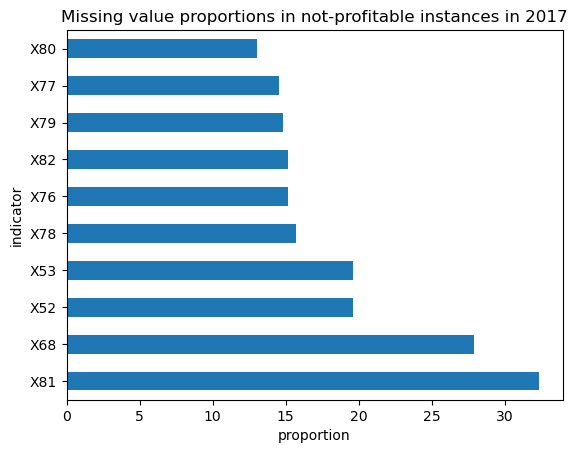

In [23]:
# We can investigate the distribution of profitability per quarter from 2017 Q1 to 2018 Q1.
zeros_x39 = df[df['X39'] == 0]


print("We can infer that there are", zeros_x39.shape[0], "instances of nonprofitable companies in the dataset, or instances with a profitability ratio of 0.")
print("Shape of unprofitable companies:", zeros_x39.shape)

#Let's check the missing values within nonprofitable companies to determine which continuous variables should be imputed vs not.
#Special attention to X81, X52, X53

np_sum = (zeros_x39.isnull().sum()/zeros_x39.shape[0]) * 100
#print(np_sum)
np_sum_sorted = np_sum.sort_values(ascending= False)

np_sum_sorted.head(10).plot.barh().figure
plt.title("Missing value proportions in not-profitable instances in 2017")
plt.xlabel('proportion')
plt.ylabel('indicator')
plt.savefig("../figures/missingvals_notprofit")
zeros_x39.head()


In [ ]:
# More granular breakdown

counted = zeros_x39.groupby(["Num"]).count()

print("There are", counted.shape[0], "notprofitable companies, or companies that have ever had a X39 value of 0.")

counted[counted['S'] > 3].shape
print("There are",counted[counted['Country'] > 3].shape[0], "companies that are always not profitable, from 2017 Q1 to 2018 to Q1.")

There are 144 notprofitable companies, or companies that have ever had a X39 value of 0.
There are 44 companies that are always not profitable, from 2017 Q1 to 2018 to Q1.


In [16]:
zeros_x39["Country"].unique()
# All countries are represented within not-profitable  


array(['Poland', 'Hungary', 'Czech Republic', 'Slovakia'], dtype=object)

In [17]:
# Little sanity check that there two partitions: non-profitable and profitable companies.

print(zeros_x39['Country'].unique())
rest_x39 = df[df['X39'] != 0]
print(rest_x39['Country'].unique())
# However, after removing rows with NaN in X39, not all countries are represented within profitable companies.

print("Two partitions?", zeros_x39.shape[0] + rest_x39.shape[0] == df.shape[0])
print(zeros_x39.shape[0] , rest_x39.shape[0])


['Poland' 'Hungary' 'Czech Republic' 'Slovakia']
['Poland' 'Hungary']
Two partitions? True
337 1155


Num         0.000000
Country     0.000000
X1          1.385281
X2          1.298701
X3          1.298701
             ...    
X80        10.043290
X81        39.047619
X82        12.640693
S           0.000000
X39         0.000000
Length: 85, dtype: float64


,Num,Country,X1,X2,X3,X4,X5,X6,X7,X8,...,X75,X76,X77,X78,X79,X80,X81,X82,S,X39
318,1,Poland,NaN,1.653157e+06,1219.14,1.06,99969.68,0.00,2.35,1.442456e+06,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,4,0.09
318,1,Poland,0.00,-2.792618e+07,7869.71,0.98,-1708848.25,0.00,2.27,-2.574991e+07,...,0.89,0.32,0.41,1.00,0.77,0.90,-2.41,-5.01,4,0.09
318,1,Poland,0.00,-1.165877e+08,22819.17,0.98,-6654070.50,0.00,2.31,-1.139175e+08,...,1.11,4.62,4.15,0.99,1.22,1.06,1.09,3.38,4,0.08
318,1,Poland,0.00,-4.353343e+07,-32104.35,1.06,-2632552.76,0.00,2.35,-4.071857e+07,...,1.14,0.96,0.79,1.14,1.06,1.19,1.06,0.61,4,0.09
86,2,Hungary,0.02,5.500000e-01,0.00,0.99,0.34,0.03,0.83,2.300000e-01,...,1.00,1.00,1.00,1.00,1.00,1.00,NaN,NaN,3,0.18


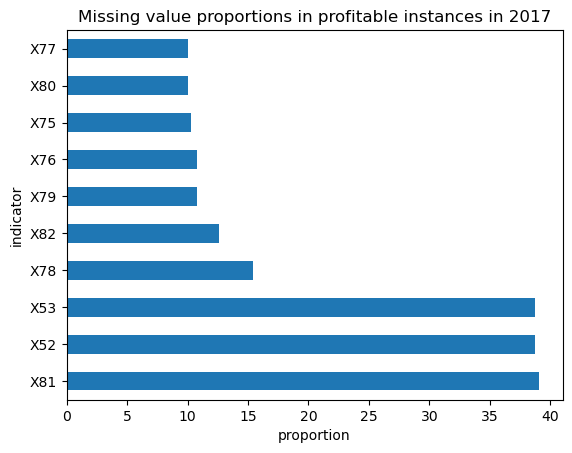

In [24]:
# Let's check the missing values within PROFITABLE companies to determine which continuous variables should be imputed vs not.
#Special attention to:
#  X81 (27%), X53 (27%); X68 (31%), X81 (30%), X77 (16%) (within non-profitable features); X53 (42%), X52 (42%), X81 (40%) (within profitable companies)

p_sum = rest_x39.isnull().sum()/rest_x39.shape[0] * 100
print(p_sum)
p_sum_sorted = p_sum.sort_values(ascending= False)


p_sum_sorted.head(10).plot.barh()
plt.title("Missing value proportions in profitable instances in 2017")
plt.xlabel('proportion')
plt.ylabel('indicator')
plt.savefig("../figures/missingvals_profit")

rest_x39.head()

# Top three features with missing features within profitable companies: X53 (42%), X52 (42%), X81 (40%)



In [25]:
# Some Data Exploration

print(df.shape)
print("The number of instances per sector:")
print(Counter(df['S']))
print(df['S'].value_counts().sum())
# We are working with an imbalanced dataset.

# Stratify split: it's imbalanced, you might randomly have patterns that you dont intend on training the data against
# Stratified group K-fold for concatenated dta

(1492, 85)
The number of instances per sector:
Counter({3: 749, 6: 245, 2: 229, 4: 172, 1: 53, 5: 44})
1492


count    85.000000
mean      4.412553
std       6.951332
min       0.000000
25%       1.206434
50%       1.407507
75%       5.026810
max      37.533512
dtype: float64

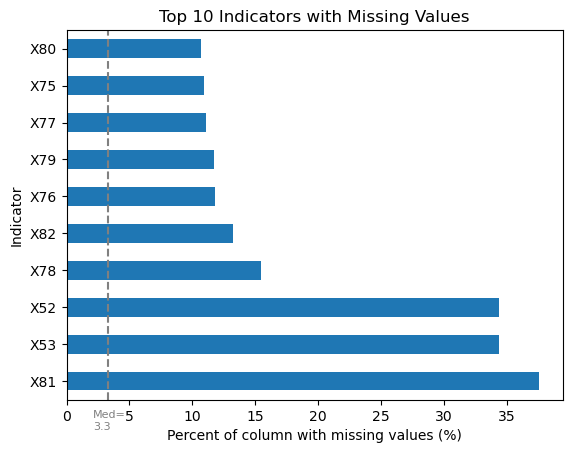

In [27]:
# Finding the columns with null values

sum = (df.isnull().sum()/df.shape[0]) * 100
#print(sum)
sum_sorted = sum.sort_values(ascending= False)


sum_sorted.head(10).plot.barh()
plt.axvline(x = 3.3, color='grey', linestyle='--', label = "Median = 4.28")
plt.text(2.1,-1.3,"Med=\n3.3",rotation=0, fontsize= 8, color = 'grey')
plt.title("Top 10 Indicators with Missing Values")
plt.xlabel("Percent of column with missing values (%)")
plt.ylabel("Indicator")
plt.savefig("../figures/top10_missingvals")

sum_sorted.head(10)

sum_sorted.describe()



### Ratios/indicators that the paper suggested as significant differently between sectors for assessing yearly/quarterly:


-Turnover ratios: X8 (Net sales revenue/total assets), X30 (Total operating revenue/total assets), X49 (Sales revenues/short-term liabilities), X50 (Sales/fixed assets) 

-Debt ratios: X25 (Total liabilities-cash)/sales revenues), X28 (Operating expenses/total liabilities)

-Size of the enterprise: X24 (Logarithm of total assets)

-Ratio for liquidity (X34) ((Current assets-inventory-receivables)/short-term liabilities)

-Profitability ratio (X39) (EBITDA */sales revenues)




In [28]:
df = df.replace( 0, 0.00000000000001)

key = ['X8', "X30", "X49", "X50", "X25", "X28", "X24", "X34", "X39"]

select_df = df[['X8', "X30", "X49", "X50", "X25", "X28", "X24", "X34", "X39"]]
select_df.head()

#Top 3 missing value breakdown: 

# X81 "Net cash flow from (used in) operating activities (n)/Net cash flow from (used in) operating activities (n−1)"
# X52 Net profit/net cash flow from (used in) operating activities
# X53 Depreciation/net cash flow from (used in) operating activities
# X68 "Market capitalization/EBITDA"
# X77 Net profit (n)/net profit (n−1)



# X81 (27%), X53 (27%), X52 (27%) overall; X68 "Market capitalization/EBITDA" (31%), X81 (30%), X77 (16%) (within non-profitable features); X53 (42%), X52 (42%), X81 (40%) (within profitable companies)

,X8,X30,X49,X50,X25,X28,X24,X34,X39
318,1.442456e+06,1.442456e+06,72.28,0.37,1.15,NaN,0.60,-92.18,0.09
318,-2.574991e+07,-2.576994e+07,78.98,0.41,1.08,0.92,NaN,-88.44,0.09
318,-1.139175e+08,-1.146559e+08,85.19,0.42,1.02,0.98,NaN,-94.61,0.08
318,-4.071857e+07,-4.095315e+07,77.49,0.40,1.07,0.94,NaN,-91.94,0.09
86,2.300000e-01,2.300000e-01,0.69,0.34,2.16,0.37,7.16,0.30,0.18


### Let move onto EDA of the new target variable. 

In [29]:
## NEW TARGET VAR: X39,Profitability ratio

df['X39'] = df['X39'].astype(float)



In [30]:
print(df.shape)
not_prof = df[df['X39'] == 0]
print(not_prof.shape, not_prof["Country"].unique())
prof = df[df['X39'] != 0]
print(prof["Country"].unique())

print(prof.shape[0] + not_prof.shape[0])
# AFTER DROPPING THE INSTANCES WHERE target attribute X39 is missing, we only have complete data for Poland and Hungary


(1492, 85)
(0, 85) []
['Poland' 'Hungary' 'Czech Republic' 'Slovakia']
1492


In [31]:
sum = df['X39'].isna().sum()
print(sum)

0


/Users/dy/opt/miniconda3/envs/data1030_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


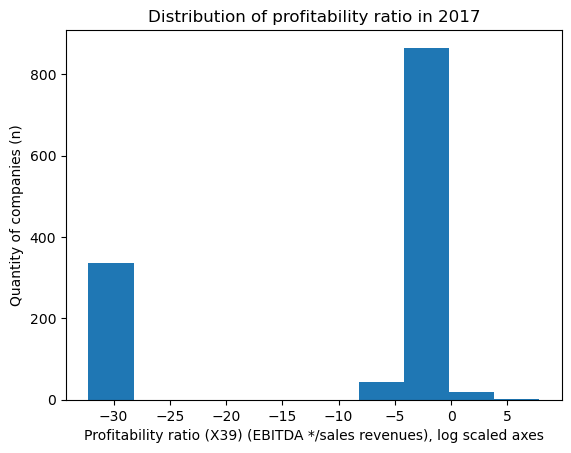

In [33]:
## VISUALIZATION 1: EDA of new target variable, X39
## Distribution of profitability ratio

df = df.replace( 0, 0.00000000000001) 


plt.hist(np.log(df['X39']))
plt.xlabel("Profitability ratio (X39) (EBITDA */sales revenues), log scaled axes")
plt.ylabel('Quantity of companies (n)')
plt.title("Distribution of profitability ratio in 2017")
plt.savefig("../figures/eda1")

# df.isna().sum()


[-32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664, -32.23619130191664,

/Users/dy/opt/miniconda3/envs/data1030_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


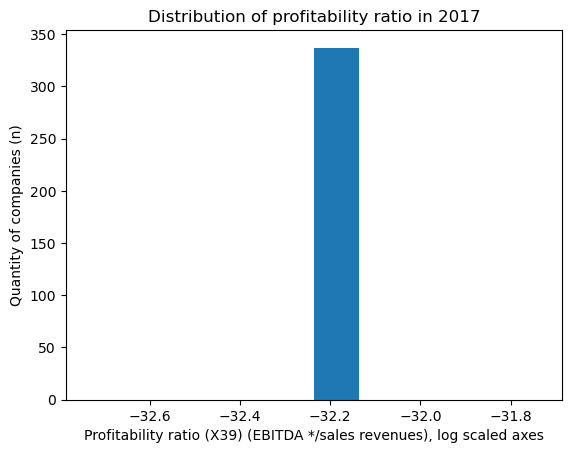

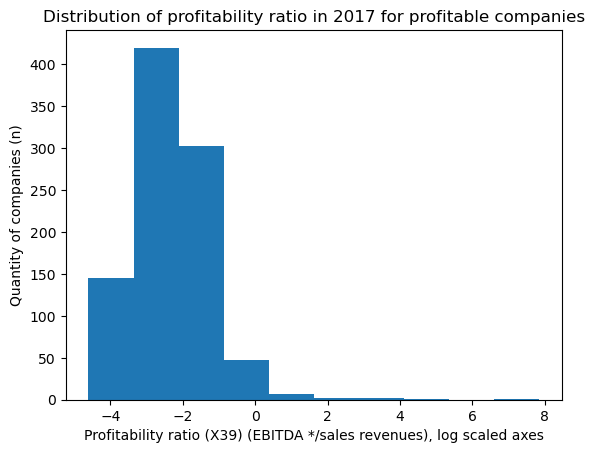

Counts of sectors for profitable companies: S
3    494
2    145
6    131
4     98
5     30
1     30
Name: count, dtype: int64
Counts of sectors for profitable companies: S
3    151
6     72
2     51
4     38
1     15
5     10
Name: count, dtype: int64


In [35]:
# Let's split the dataset into non-profitable and profitable companies.


series = np.log(df['X39'])
print(sorted(series))

low_df = df[np.log(df['X39']) < -20]
print("Unique countries in not-profitable co.s:", low_df["Country"].unique())
high_df = df[np.log(df['X39']) > -20]
print("Unique countries in profitable co.s:", high_df["Country"].unique())

print(low_df.shape[0] + high_df.shape[0])
print(df.shape[0])

print(high_df['X39'].describe())
print(low_df['X39'].describe())

plt.hist(np.log(low_df['X39']))
plt.xlabel("Profitability ratio (X39) (EBITDA */sales revenues), log scaled axes")
plt.ylabel('Quantity of companies (n)')

plt.title("Distribution of profitability ratio in 2017")
plt.savefig("../figures/eda1_peak")
plt.show()

plt.hist(np.log(high_df["X39"]))
plt.xlabel("Profitability ratio (X39) (EBITDA */sales revenues), log scaled axes")
plt.ylabel('Quantity of companies (n)')
plt.title("Distribution of profitability ratio in 2017 for profitable companies")
plt.savefig("../figures/eda1_dist")
plt.show()

profit_counts = high_df['S'].value_counts()
print("Counts of sectors for profitable companies:", profit_counts)

nonprofit_counts = low_df['S'].value_counts()
print("Counts of sectors for profitable companies:", nonprofit_counts)

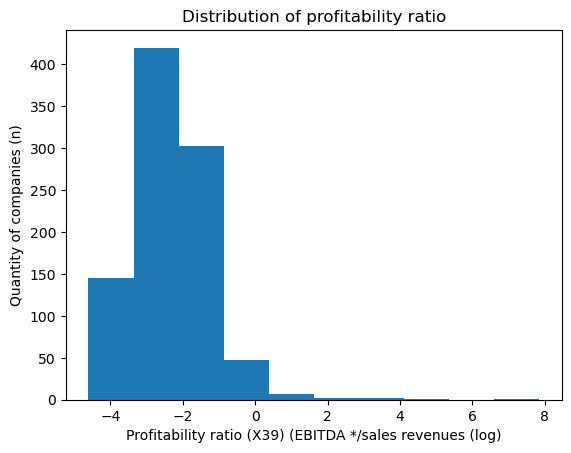

In [36]:
#Distribution of profitability ratio within profitable companies, log scaled

plt.hist(np.log(high_df["X39"]))
plt.xlabel("Profitability ratio (X39) (EBITDA */sales revenues (log)")
plt.ylabel('Quantity of companies (n)')
plt.title("Distribution of profitability ratio")
plt.show()

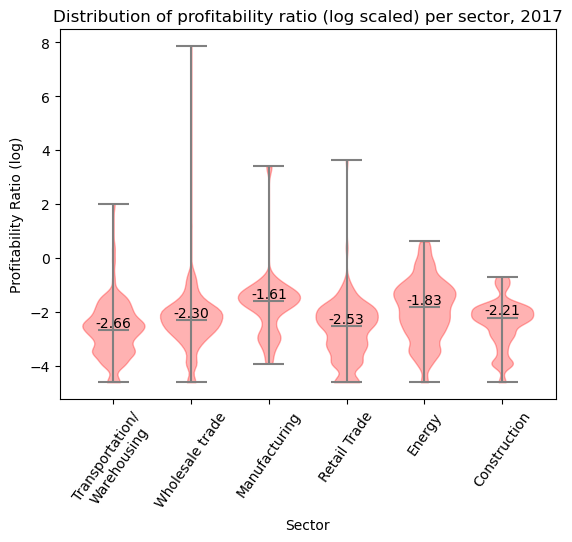

count    98.000000
mean     -2.643616
std       1.049426
min      -4.605170
25%      -3.506558
50%      -2.659260
75%      -2.040221
max       2.020222
Name: X39, dtype: float64
count    494.000000
mean      -2.313335
std        1.064534
min       -4.605170
25%       -2.813411
50%       -2.302585
75%       -1.897120
max        7.848543
Name: X39, dtype: float64
count    30.000000
mean     -1.726436
std       1.267801
min      -3.912023
25%      -2.357778
50%      -1.610689
75%      -1.255739
max       3.401197
Name: X39, dtype: float64
count    145.000000
mean      -2.693301
std        1.133713
min       -4.605170
25%       -3.506558
50%       -2.525729
75%       -1.966113
max        3.637586
Name: X39, dtype: float64
count    131.000000
mean      -1.902777
std        1.162781
min       -4.605170
25%       -2.659260
50%       -1.832581
75%       -1.139434
max        0.615186
Name: X39, dtype: float64
count    30.000000
mean     -2.400983
std       0.914675
min      -4.605170
25%      -

In [38]:
## VISUALIZATION 2: 
## Mean and median ratio per sector


# df = pd.read_csv('/Users/dy/Desktop/DATA1030/DATA1030-Fall2024/term_project/V4 data/2017.csv')
# df = df.replace("m", np.nan)
# df = df.replace( 0, 0.0000001) 
# df['X39'] = df['X39'].astype(float)

# hdf = df[np.log(df['X39']) > -10]

#high_df["X39"] = np.log(high_df["X39"])


key = [ "X39"]
df_copy = high_df.copy()
df_copy["X39"] = np.log(df_copy["X39"])
for i in key:
    smaller = df_copy[[i, 'S']]
    clean = smaller.dropna()
    #clean[i] = clean[i].astype(float)

    grouped_data = [clean[i][clean['S'] == category] for category in clean['S'].unique()]
    #print(len(grouped_data))
    #for i in grouped_data : print(len(i))
    medians = [np.median(d) for d in grouped_data]
    # print(medians)

    fig, ax = plt.subplots()
    parts = ax.violinplot(grouped_data, positions=np.arange(1,7,1),widths=0.8, bw_method=0.2, showmedians= True)


    #Labeling median values. We see high variation in the data so we choose the median to compare.
    medians = [np.median(d) for d in grouped_data]


    for i, median in enumerate(medians):
        ax.text(i + 1, median, f'{median:.2f}', 
                horizontalalignment='center', 
                verticalalignment='bottom', 
                color='black')

    for partname in ('cbars','cmins','cmaxes','cmedians'):
        bars = parts[partname]
        bars.set_edgecolor("Grey")

    for vp in parts['bodies']:
        vp.set_facecolor("red")
        vp.set_edgecolor("Red")


    plt.xticks(ticks=np.arange(1,7,1),labels = ["Transportation/\nWarehousing", "Wholesale trade","Manufacturing", "Retail Trade", "Energy", "Construction"], rotation=55)
    plt.xlabel("Sector")
    plt.ylabel("Profitability Ratio (log)")

    #plt.violinplot(grouped_data, positions=np.arange(1,7,1),widths=0.8, bw_method=0.2, showmedians=True)
    plt.title("Distribution of profitability ratio (log scaled) per sector, 2017")
    plt.savefig("../figures/eda2")
    plt.show()
    for j in grouped_data: print(j.describe())






/Users/dy/opt/miniconda3/envs/data1030_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Country         Czech Republic   Hungary    Poland  Slovakia
profit                                                      
Not Profitable        0.005319  0.012411  0.976950  0.005319
Profitable                 NaN  0.010776  0.989224       NaN


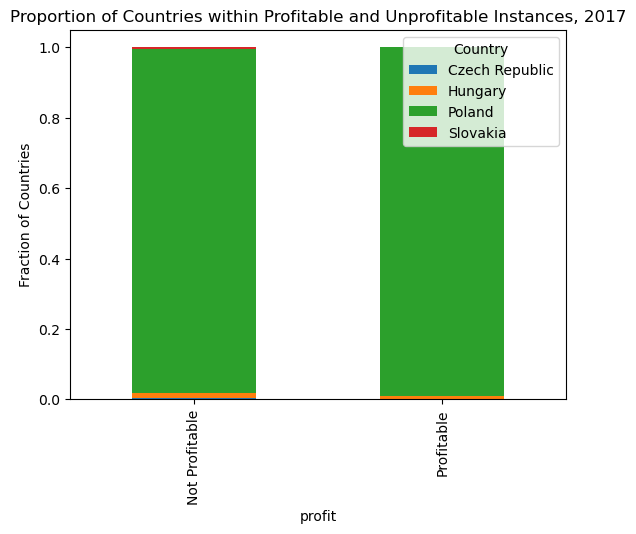

In [40]:
# EDA 3: For each partition (profitable and non-profitable companies), what is the breakdown of sectors? Of countries?


cat_df = df.copy()

cat_df['X39'] = np.log(cat_df['X39'])

cat_df['profit'] = np.where(cat_df['X39'] > -10, 'Profitable', 'Not Profitable')



count_matrix = cat_df.groupby(['profit', 'Country']).size().unstack()

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print(count_matrix_norm)

count_matrix_norm.plot(kind="bar", stacked = True)
plt.title("Proportion of Countries within Profitable and Unprofitable Instances, 2017")
plt.ylabel("Fraction of Countries")
plt.savefig("../figures/eda3_byprofit")




profit          Not Profitable  Profitable
Country                                   
Czech Republic        1.000000         NaN
Hungary               0.411765    0.588235
Poland                0.375085    0.624915
Slovakia              1.000000         NaN


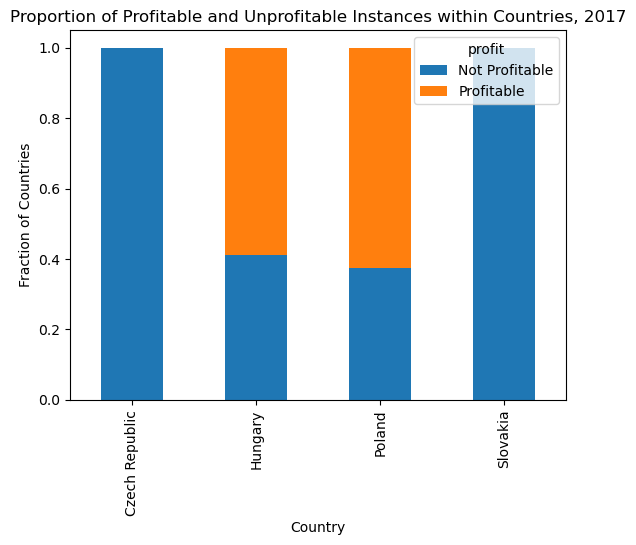

In [42]:
#By country
count_matrix = cat_df.groupby(['Country', 'profit']).size().unstack()

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print(count_matrix_norm)

count_matrix_norm.plot(kind="bar", stacked = True)
plt.title("Proportion of Profitable and Unprofitable Instances within Countries, 2017")
plt.ylabel("Fraction of Countries")
plt.savefig("../figures/eda3_bycountry")


In [43]:
cat_df[cat_df['profit'] == "Profitable"]['Country'].unique()

array(['Poland', 'Hungary'], dtype=object)

0
profit          Not Profitable  Profitable
Country                                   
Czech Republic             3.0         NaN
Hungary                    7.0        10.0
Poland                   551.0       918.0
Slovakia                   3.0         NaN
Index(['Not Profitable', 'Profitable'], dtype='object', name='profit')


Text(0, 0.5, 'Fraction of Sectors')

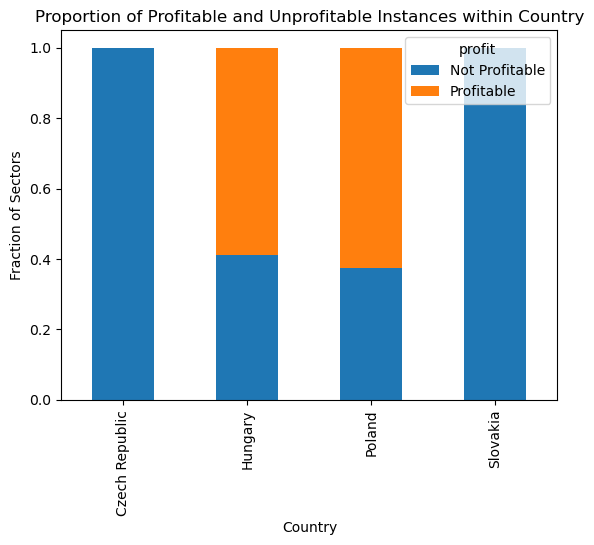

In [44]:
# EDA 3: Breakdown of sectors by profitable and unprofitable countries


sectors = {1: "Transportation/Warehousing", 2:"Wholesale trade", 3:"Manufacturing", 4: "Retail Trade", 5: 'Energy', 6: "Construction"}

sectors_l = ["Transportation/\nWarehousing", "Wholesale trade","Manufacturing", "Retail Trade", "Energy", "Construction"]

# cat_df['S'] = cat_df['S'].map(sectors)

# cat_df_renamed = cat_df.rename(columns = {'S':'Sector'})

print(cat_df['S'].isna().sum())

cnt_matrix = cat_df.groupby(['profit', 'S']).size().unstack()
print(count_matrix)

cnt_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print(cnt_matrix_norm.columns)



cnt_matrix_norm.plot(kind="bar", stacked = True)



plt.title("Proportion of Profitable and Unprofitable Instances within Country")
plt.ylabel("Fraction of Sectors")

profit  Not Profitable  Profitable
S                                 
1                   23          30
2                   84         145
3                  255         494
4                   74          98
5                   14          30
6                  114         131
profit  Not Profitable  Profitable
S                                 
1             0.433962    0.566038
2             0.366812    0.633188
3             0.340454    0.659546
4             0.430233    0.569767
5             0.318182    0.681818
6             0.465306    0.534694
Index(['Not Profitable', 'Profitable'], dtype='object', name='profit')


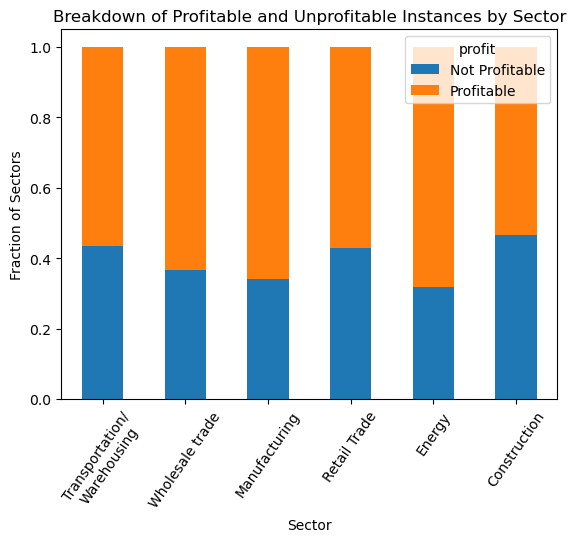

In [46]:
matrix = cat_df.groupby(['S', 'profit']).size().unstack()
print(matrix)

matrix_norm = matrix.div(matrix.sum(axis=1),axis=0)
print(matrix_norm)
print(matrix_norm.columns)

matrix_norm.plot(kind="bar", stacked = True)

plt.title("Breakdown of Profitable and Unprofitable Instances by Sector")
plt.xticks(ticks=np.arange(0,6,1),labels = ["Transportation/\nWarehousing", "Wholesale trade","Manufacturing", "Retail Trade", "Energy", "Construction"], rotation=55)
plt.xlabel("Sector")
plt.ylabel("Fraction of Sectors")
plt.savefig("../figures/eda3_bysector")
plt.show()


# End EDA of New Target Feature

###  Visualizing the distribution of sectors. 

Text(0.5, 1.0, 'Distribution of Sectors of V4 Companies in 2017')

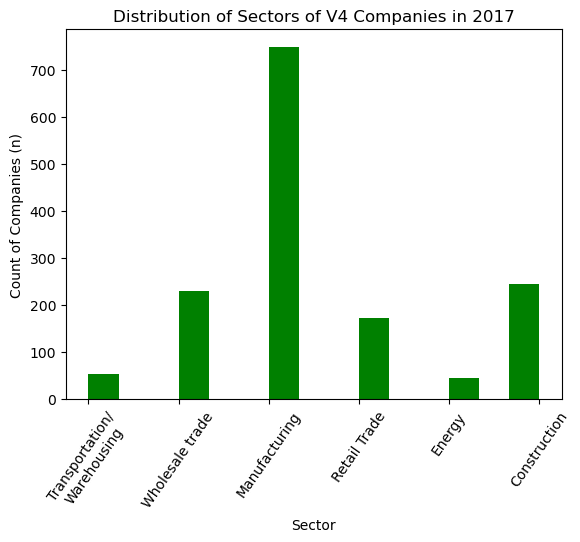

In [47]:
'''
Visualizing the distribution of sectors.
1. Transportation and warehousing; 2. Wholesale trade; 3. Manufacturing; 4. Retail trade; 5. Energy; 6. Construction.
'''

plt.hist(df['S'], bins = 15, color='green')
plt.ylabel("Count of Companies (n)")
plt.xlabel("Sector")
plt.xticks(ticks= np.arange(1,7,1), labels = ["Transportation/\nWarehousing", "Wholesale trade","Manufacturing", "Retail Trade", "Energy", "Construction"], rotation=55)
#plt.set_xlabel()
plt.title("Distribution of Sectors of V4 Companies in 2017")

### Visualizing working capital by sector below. Histogram, violin plots, barplots.

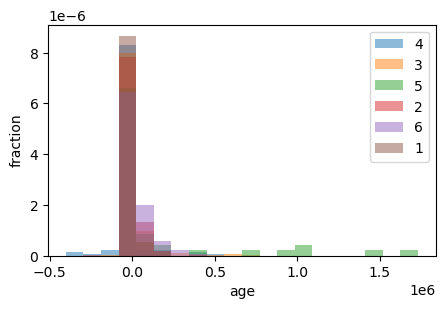

In [49]:
categories = df['S'].unique()
bin_range = (df['X44'].min(),df['X44'].max())

plt.figure(figsize=(5,3))

for c in categories:
        plt.hist(df[df['S']==c]['X44'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('fraction')
plt.xlabel('age')
plt.show()

                   0
count      53.000000
mean    10066.040377
std     28223.877540
min    -23622.850000
25%        30.000000
50%       932.300000
75%      5047.000000
max    138179.700000
                   0
count     229.000000
mean    14729.511354
std     38310.280262
min     -6178.940000
25%        55.000000
50%      1384.230000
75%      9993.980000
max    371125.730000
                  0
count  7.450000e+02
mean   2.180207e+04
std    8.198257e+04
min   -2.273476e+05
25%    1.000000e-14
50%    1.526000e+03
75%    1.132200e+04
max    7.223730e+05
                   0
count     172.000000
mean     6038.250930
std     90603.443142
min   -402393.260000
25%      -155.500000
50%       378.500000
75%      4357.045000
max    452993.000000
                  0
count  4.400000e+01
mean   1.782682e+05
std    4.158714e+05
min   -6.989027e+04
25%    1.000000e-14
50%    2.298440e+03
75%    7.967683e+04
max    1.731427e+06
                  0
count  2.450000e+02
mean   3.306999e+04
std    6.7285

/Users/dy/opt/miniconda3/envs/data1030_env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Text(0.5, 1.0, 'Working capital (X44) between different sectors of V4 companies in 2017')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


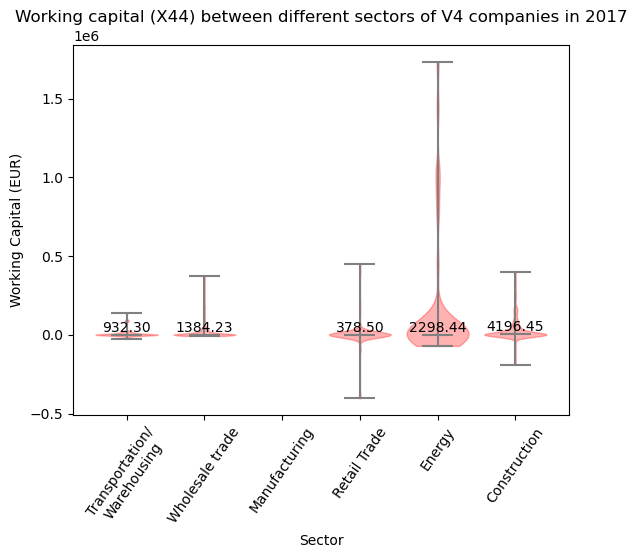

In [51]:
# Violin plots by sector of working capital, X44. With Medians
fixed_dataset = [df[df['S']==1]['X44'].values,
           df[df['S']==2]['X44'].values,
           np.delete(df[df['S']==3]['X44'].values, 6),
           df[df['S']==4]['X44'].values,
           df[df['S']==5]['X44'].values,

           df[df['S']==6]['X44'].values]

for j in fixed_dataset: 
    j = pd.DataFrame(j)
    print(j.describe())

fig, ax = plt.subplots()
parts = ax.violinplot(fixed_dataset, positions=np.arange(1,7,1),widths=0.8, bw_method=0.2, showmedians= True)


# Labeling median values. We see high variation in the data so we choose the median to compare.
medians = [np.median(d) for d in fixed_dataset]


for i, median in enumerate(medians):
    ax.text(i + 1, median, f'{median:.2f}', 
            horizontalalignment='center', 
            verticalalignment='bottom', 
            color='black')

for partname in ('cbars','cmins','cmaxes','cmedians'):
    bars = parts[partname]
    bars.set_edgecolor("Grey")

for vp in parts['bodies']:
    vp.set_facecolor("red")
    vp.set_edgecolor("Red")



plt.xticks(ticks=np.arange(1,7,1),labels = ["Transportation/\nWarehousing", "Wholesale trade","Manufacturing", "Retail Trade", "Energy", "Construction"], rotation=55)
plt.xlabel("Sector")
plt.ylabel("Working Capital (EUR)")
plt.title("Working capital (X44) between different sectors of V4 companies in 2017")

#plt.yscale('log')

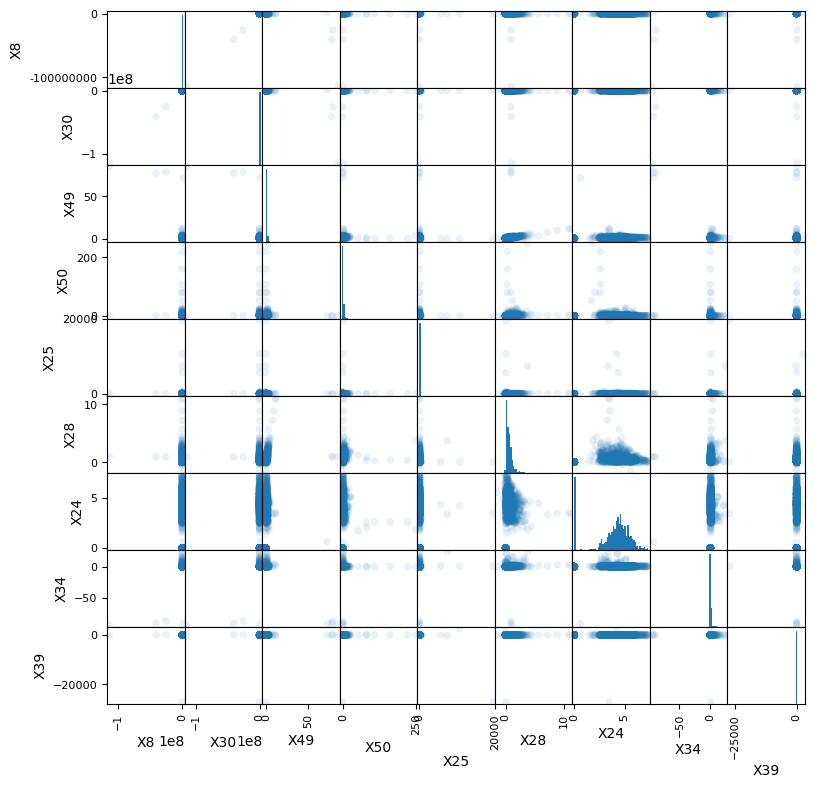

In [53]:
#Scatter plots of select features.
axl = pd.plotting.scatter_matrix(select_df.select_dtypes(float), figsize=(9, 9), marker='o',hist_kwds={'bins': 50}, 
                           s=30, alpha=.1)
# for i, axs in enumerate(axl):
#     for j, ax in enumerate(axs):
#         if i != j:  # only the scatter plots
#             ax.set_xscale('log')
#             ax.set_yscale('log')
plt.show()

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31',
       'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X40', 'X41', 'X42',
       'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52',
       'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62',
       'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72',
       'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82',
       'X39'],
      dtype='object')
82


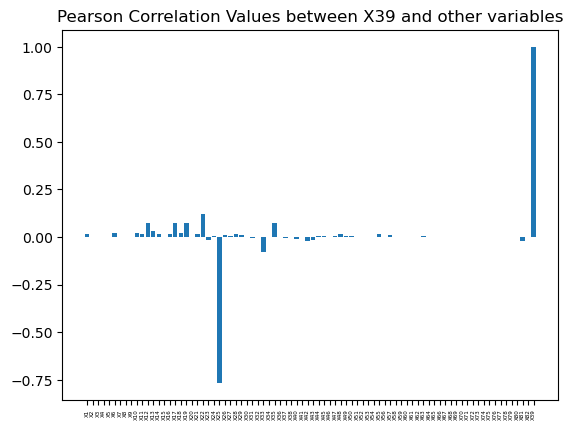

[('X25', -0.76630287891739), ('X33', -0.07956786530379009), ('X81', -0.020332097578830553), ('X42', -0.01979114350820323), ('X43', -0.01574591098723788), ('X23', -0.015221381617890115), ('X40', -0.009201319916811796), ('X37', -0.0041273150067842835), ('X31', -0.0037993373685264345), ('X4', -0.002457991148350424), ('X34', -0.0019061001186906226), ('X52', -0.001440487137509312), ('X82', -0.0010480990015637518), ('X5', -0.0009249692650140354), ('X41', -0.0009195959228093714), ('X9', -0.0009130094608662982), ('X32', -0.0009129224383477618), ('X2', -0.0009127830528122894), ('X20', -0.0009126981410108073), ('X8', -0.000903629590757477), ('X30', -0.0009030832066132243), ('X38', -0.0008910796634636376), ('X76', -0.0007487750047861841), ('X69', -0.0005810317515543835), ('X56', -0.0004173309289908447), ('X61', -0.0003720092720096461), ('X79', -0.00036375405417339655), ('X77', -0.00034224790507120917), ('X58', -0.00020418450287919894), ('X3', -9.64766709030606e-06), ('X65', 1.4344890338615832e-17

In [54]:
# Pearson Correlation matrix of selected indicators from paper
cont_df = df.drop(columns=["S", 'Country', "Num"])
print(cont_df.columns)
print(len(cont_df.columns))
#pearson = cont_df.corr('pearson')
# col_names = pearson.columns
# pearson_arr = pearson.to_numpy(float)
# pearson_arr = np.round(pearson_arr,2)


pearson = np.zeros(len(cont_df.columns))
for i in range(len(cont_df.columns)): 
    correlation_coefficient = df['X39'].corr(df[cont_df.columns[i]], method='pearson')
    #print(correlation_coefficient)
    pearson[i] = correlation_coefficient


#print(pearson)

plt.bar(range(len(pearson)),pearson)
plt.xticks(range(len(pearson)), cont_df.columns)
plt.xticks(rotation=90) 
plt.title("Pearson Correlation Values between X39 and other variables")
plt.tick_params(axis='x', labelsize=4)
plt.show()

zipped = zip(cont_df.columns, pearson)

sorted_list = sorted(zipped, key=lambda x: x[1], reverse = False)

print(sorted_list)

# We can see from a Pearson Correlation that X12, X19, X35 and X17 are highly (positive) correlated (Pearson correlation value > 0.6)
# X12 = (Gross profit + depreciation)/sales revenues
# X17 = Gross profit/sales revenues
# X19 = Net profit/sales revenues
# X35 = EBIT/sales revenue

# X24



# Data Preprocessing Below

We need to make our feature matrix and target attribute series. We also need to encode categorical features and scale numeric features.

In [55]:
df.columns

Index(['Num', 'Country', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29',
       'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X40',
       'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50',
       'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60',
       'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70',
       'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80',
       'X81', 'X82', 'S', 'X39'],
      dtype='object')

In [ ]:
# Obtaining categorical and numeric features lists
cat_feats = ['Country', 'S']
num_feats = list(df.columns)
print(num_feats)

to_remove = cat_feats + ["X39", 'Num'] 
for i in to_remove:
    print(i)
    num_feats.remove(i)

print(num_feats)


['Num', 'Country', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'S', 'X39']
Country
S
X39
Num
['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X

In [57]:
#There are no missing values for categorical features
for i in cat_feats:
    print(df[i].isna().sum())

0
0


### Making target series and feature matrix

In [58]:

tar = df['X39']
print(tar.isna().sum())


f_mat = df.drop(columns=['X39'])

groups = df['Num']

f_mat = f_mat.drop(columns = ["Num"])



0


In [59]:
df['Num'].unique()
print(len(df['Num'].unique()))

393


In [60]:
f_mat.info()
#f_mat['X39']

<class 'pandas.core.frame.DataFrame'>
Index: 1492 entries, 318 to 317
Data columns (total 83 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  1492 non-null   object 
 1   X1       1474 non-null   float64
 2   X2       1475 non-null   float64
 3   X3       1472 non-null   float64
 4   X4       1471 non-null   float64
 5   X5       1475 non-null   float64
 6   X6       1475 non-null   float64
 7   X7       1474 non-null   float64
 8   X8       1475 non-null   float64
 9   X9       1475 non-null   float64
 10  X10      1474 non-null   float64
 11  X11      1474 non-null   float64
 12  X12      1446 non-null   float64
 13  X13      1478 non-null   float64
 14  X14      1474 non-null   float64
 15  X15      1474 non-null   float64
 16  X16      1473 non-null   float64
 17  X17      1446 non-null   float64
 18  X18      1474 non-null   float64
 19  X19      1445 non-null   float64
 20  X20      1475 non-null   float64
 21  X21      1473 non-

In [61]:
tar.info()

<class 'pandas.core.series.Series'>
Index: 1492 entries, 318 to 317
Series name: X39
Non-Null Count  Dtype  
--------------  -----  
1492 non-null   float64
dtypes: float64(1)
memory usage: 55.6 KB


## Initializing the preprocessor

In [62]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_feats),
        ('cat', categorical_transformer, cat_feats)])

## Calculating the baseline score

In [63]:
# Calculating baseline score
from sklearn.metrics import mean_squared_error
# impute the baseline evaluation score
baseline_df = df.copy()
baseline_df['baseline_pred'] = baseline_df.groupby('Num')['X39'].transform('mean')
print(baseline_df.head())
base_score = np.sqrt(mean_squared_error(baseline_df['baseline_pred'], baseline_df['X39']))

print("baseline rmse score:", base_score)


     Num  Country            X1            X2            X3    X4          X5  \
318    1   Poland           NaN  1.653157e+06  1.219140e+03  1.06    99969.68   
318    1   Poland  1.000000e-14 -2.792618e+07  7.869710e+03  0.98 -1708848.25   
318    1   Poland  1.000000e-14 -1.165877e+08  2.281917e+04  0.98 -6654070.50   
318    1   Poland  1.000000e-14 -4.353343e+07 -3.210435e+04  1.06 -2632552.76   
86     2  Hungary  2.000000e-02  5.500000e-01  1.000000e-14  0.99        0.34   

               X6    X7            X8  ...   X76   X77   X78   X79   X80  \
318  1.000000e-14  2.35  1.442456e+06  ...  1.00  1.00  1.00  1.00  1.00   
318  1.000000e-14  2.27 -2.574991e+07  ...  0.32  0.41  1.00  0.77  0.90   
318  1.000000e-14  2.31 -1.139175e+08  ...  4.62  4.15  0.99  1.22  1.06   
318  1.000000e-14  2.35 -4.071857e+07  ...  0.96  0.79  1.14  1.06  1.19   
86   3.000000e-02  0.83  2.300000e-01  ...  1.00  1.00  1.00  1.00  1.00   

      X81   X82  S   X39  baseline_pred  
318  1.00  1.0

# Function for reduced features model, linear and non-linear models

In [64]:


from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  GroupShuffleSplit, GroupKFold

######

# function for the ML pipeline as outlined above 
def MLpipe_linear_RMSE(X, y, preprocessor, ML_algo, param_grid, grps):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.

    You should:

    1. Loop through 10 different random states
    2. Split your data 
    3. Fit a model using GridSearchCV with KFold and the predefined Preprocessor 
    4. Calculate the model's error on the test set 
    5. Return a list of 10 test scores and 10 best models 
    '''
    def rmse(predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())
    
    #use make_scorer to minimize RMSE
    rmse_scor = make_scorer(rmse, greater_is_better=False)

    # lists to be returned 
    test_scores = [] # list of scores, each score was the best among all the folds
    best_models = [] # list of sets of best models our of 4 folds, one per pattern
    
    avg_test = [] # list of average fold score
    ret_patts = [] # list of sets of patterns, same len as best_models
    X_tests = [] # list of X_tests
    y_test_sets = []

    pred_results = [] #list of y_preds for y_tests
    
    prepro = Pipeline(steps=[('preprocessor', preprocessor)])

    rand_states = range(10,15) 

    #reset the indices of X and y bc they are originally indexed by Num but 
    X_reind = X.reset_index(drop = False)
    y_reind = y.reset_index(drop = False)


    for i in rand_states: # for 10 random states, 10 random shuffles
        print("random state:", i)
        #first split: test & other
        gss = GroupShuffleSplit(n_splits = 1, test_size = 0.2) # 1 split makes GroupTimeSeriesSplit equivalent to train_test_split?

        X_other, y_other, groups_other = [], [], []
        X_test, y_test = [], []
        for other_idx, test_idx in gss.split(X, y, grps):
            X_other, y_other, groups_other = X_reind.drop(columns= 'index').iloc[other_idx], y_reind.drop(columns= 'index').iloc[other_idx], groups.iloc[other_idx]
            X_test, y_test, groups_test = X_reind.drop(columns= 'index').iloc[test_idx], y_reind.drop(columns= 'index').iloc[test_idx], groups.iloc[test_idx]

        

        # Preprocess
        # Preprocessing converts 2D DF into 2D numpy array
        X_other = prepro.fit_transform(X_other) 
        feature_names = preprocessor.get_feature_names_out()
        X_test = prepro.transform(X_test)

        #To test why number of transformed features is different

        # Convert X_other and X_test to df to use iloc, X_test later
        X_other = pd.DataFrame(data = X_other, columns = feature_names, index=y_other.index)


        #print("After Preprocessing, X_other shape:",X_other.shape)
        #Second split: train and val sets
        gtss_cv = GroupKFold(n_splits=4) #4 splits
        
        test_scores_split = [] # get a set of scores for Kfold splits and choose the item in patt_models (indexed on patterns) between all 4 splits

        # Arrays to keep items to choose from based on best fold score
        patterns = [] #len == 4, keep pattern sets in here
        patt_models = [] # len == 4, keep model sets per fold in here
        split_y_preds = [] # len == 4, keep predictions for X_test per fold in here

        y_tests_folds = []
        X_tests_folds = []
        

        #will iterate 4 times 
        count = 1
        for train_idx, val_idx in gtss_cv.split(X= X_other, y=y_other, groups = groups_other):
            
            print("fold:", count)
            fold_models = [] # contains all the trained models for each pattern

            # print("TRAIN:", train_idx, "Val:", val_idx)
            # print("\t Train size %:", len(train_idx)/X.shape[0], "Val size %:", len(val_idx)/X.shape[0])
            # print("\t Train size:", len(train_idx), "Val size %:", len(val_idx),"Test size %:", len(test_idx))

            # SPLIT 2
            X_train, y_train, groups_train = X_other.iloc[train_idx], y_other.iloc[train_idx], groups_other.iloc[train_idx]
            X_val, y_val, groups_val = X_other.iloc[val_idx], y_other.iloc[val_idx], groups_other.iloc[val_idx]

            X_train_df = pd.DataFrame(data = X_train.values, columns = feature_names, index=y_train.index)
            X_val_df = pd.DataFrame(data = X_val.values, columns = feature_names, index=y_val.index)
            X_test_df = pd.DataFrame(data = X_test, columns = feature_names, index=y_test.index)

            # REDUCED FEATURES
            #print("Reduced Features... \n")

            # find all unique patterns of missing value in test set
            mask = X_test_df.isna()
            unique_rows = np.array(np.unique(mask, axis=0))
            patterns.append(unique_rows) # 
            all_y_test_pred = pd.DataFrame()

            #print('\t there are', len(unique_rows), 'unique missing value patterns.')

            # divide test sets into subgroups according to the unique patterns
            for i in range(len(unique_rows)):
                #print ('working on unique pattern', i)
                #print("Pattern:", unique_rows[i])

                ## generate X_test subset that matches the unique pattern i
                sub_X_test = pd.DataFrame()
                sub_y_test = pd.Series(dtype=float)
                for j in range(len(mask)): # check each row in mask
                    row_mask = np.array(mask.iloc[j])
                    if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern
                        sub_X_test = pd.concat([sub_X_test,X_test_df.iloc[[j]]])# append the according X_test row j to the subset
                        sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])# append the according y_test row j

                sub_X_test = sub_X_test[X_test_df.columns[~unique_rows[i]]]
                #print("sub_X_test shape", sub_X_test.shape)
                
                ## choose the according reduced features for subgroups
                sub_X_train = pd.DataFrame()
                sub_y_train = pd.DataFrame()
                sub_X_val = pd.DataFrame()
                sub_y_val = pd.DataFrame()

                # 1.cut the feature columns that have nans in the according sub_X_test
                sub_X_train = X_train_df[X_train_df.columns[~unique_rows[i]]]
                sub_X_val = X_val_df[X_val_df.columns[~unique_rows[i]]]

                # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
                sub_X_train = sub_X_train.dropna()
                sub_X_val = sub_X_val.dropna()  

                # 3.cut the sub_Y_train and sub_y_CV accordingly
                sub_y_train = y_train.loc[sub_X_train.index]
                sub_y_val = y_val.loc[sub_X_val.index]

                
                # # change to 1-D array to avoid warnings
                sub_y_train_array = sub_y_train.values.ravel()
                sub_y_val_array = sub_y_val.values.ravel()
                sub_y_test_array = sub_y_test.values.ravel()

            
                #For each pattern, train the ML model
                ml = ML_algo
                pg = ParameterGrid(param_grid)
                scores = np.zeros(len(pg))
                # print(len(scores))

                # FINDING THE BEST PARAMETERS FOR A GIVEN PATTERN
                for i in range(len(pg)):
                    params = pg[i]
                    ml.set_params(**params)

                    ml.fit(sub_X_train, sub_y_train_array)
                    sub_y_val_pred = ml.predict(sub_X_val)
                    scores[i] = np.sqrt(mean_squared_error(sub_y_val_array, sub_y_val_pred))
                    #print('\t\t val_score:', scores[i])

                best_params = np.array(pg)[scores == np.min(scores)]

                # test the model on the test set with best parameter set for each pattern
                ml.set_params(**best_params[0])
                ml.fit(sub_X_train, sub_y_train_array)

                fold_models.append(ml) # add the best model for each pattern.
                sub_y_test_pred = pd.DataFrame(ml.predict(sub_X_test), index = sub_y_test.index,
                                            columns = ['sub_y_test_pred']) # convert in to data frame
                all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])
                

            patt_models.append(fold_models) #there should be 4 sets of models, with the same number of models as patterns

            # all y predictions, after running through all of the patterns
            all_y_test_pred = all_y_test_pred.sort_index()
            split_y_preds.append(all_y_test_pred)

            y_test = y_test.sort_index()
            X_test = X_test_df.sort_index()
            # ensures that all X_test, y_test, and y_preds are all indexed the same
            X_tests_folds.append(X_test)
            y_tests_folds.append(y_test)

            
            # print("LOOK HERE!!! ")
            # print("all_y_test_pred shape", all_y_test_pred.shape)
            # print("y_test shape", y_test.shape)
            
            # calculate rmse for each fold
            eval_score = np.sqrt(mean_squared_error(all_y_test_pred, y_test))
            test_scores_split.append(eval_score)

            
            count += 1
        
        avg_test_folds = np.mean(test_scores_split)
        print(f'overall test mean for splits: {avg_test_folds}')
        print(f'overall test std for splits: {np.std(test_scores_split)}\n')
        avg_test.append(avg_test_folds)

        # choosing the best sets of models, corresponding patterns, and predictions
        best_patt_models = np.array(patt_models)[test_scores_split == np.min(test_scores_split)]
        best_patterns = np.array(patterns)[test_scores_split == np.min(test_scores_split)]
        best_preds = np.array(split_y_preds)[test_scores_split == np.min(test_scores_split)]
        best_X_test = np.array(X_tests_folds)[test_scores_split == np.min(test_scores_split)]
        best_y_test = np.array(y_tests_folds)[test_scores_split == np.min(test_scores_split)]


        pred_results.append(np.squeeze(best_preds[0]))

        # based on the best average score of the folds, pick the best set of models and their corresponding patterns

        
            #print('best_models == test_scores length:', len(best_models) == len(test_scores))
        #We get four lists of models and test_scores
        X_tests.append(best_X_test[0])
        y_test_sets.append(best_y_test[0])
        best_models.append(best_patt_models[0]) # best set of models (for each pattern)
        test_scores.append(np.min(test_scores_split)) # best fold score
        ret_patts.append(best_patterns[0]) # best patterns (best_patterns should be the same length as best_patt_models)
    #should be 10
    print('length of test scores', len(test_scores))
    print('length of best models', len(best_models))
    print('length of avg scores over 4 folds', len(avg_test)) 
    print('length of best patterns', len(ret_patts))
    print('length of pred results', len(pred_results))
    print('length of y_test', len(y_test_sets))


    return test_scores, best_models, avg_test, ret_patts, pred_results, y_test_sets, X_tests




In [65]:
# test your function with a linear regression model (l1 regularization)
import random

random.seed(3)

import time
from sklearn.linear_model import Lasso
start_time = time.time()
model = Lasso(max_iter=1000000000)
param = {'alpha': [x for x in np.logspace(-2,2,21)]}
ltest_scores, lbest_models, lavg_test, lret_patts, lpred_results, ly_test_sets, lX_tests  = \
    MLpipe_linear_RMSE(f_mat, tar, preprocessor,model,param, groups)
print('LASSO reduced features model running time:', time.time()-start_time)



#485.86557388305664, 8 mins and 5 secs


random state: 10
fold: 1
fold: 2
fold: 3
fold: 4
overall test mean for splits: 149.39933057236283
overall test std for splits: 0.02947972317280927

random state: 11
fold: 1
fold: 2
fold: 3
fold: 4
overall test mean for splits: 5.582480343075664
overall test std for splits: 0.131572267905516

random state: 12
fold: 1
fold: 2
fold: 3
fold: 4
overall test mean for splits: 19.0846083144553
overall test std for splits: 13.45839925106793

random state: 13
fold: 1
fold: 2
fold: 3
fold: 4
overall test mean for splits: 1578.6977130521987
overall test std for splits: 12.682215935735963

random state: 14
fold: 1
fold: 2
fold: 3
fold: 4
overall test mean for splits: 6.741259753107853
overall test std for splits: 0.8370333769128149

length of test scores 5
length of best models 5
length of avg scores over 4 folds 5
length of best patterns 5
length of pred results 5
length of y_test 5
LASSO reduced features model running time: 142.5567970275879


In [67]:
print("average RMSE for lasso",np.mean(ltest_scores))
print("std for lasso", np.std(ltest_scores))

average RMSE for lasso 347.38999934034774
std for lasso 614.5187453522174


Variable column number is due to the presence of Czech Republic in the X_other set... when "Czech Republic" is not a value in the Country column, there are 90 columns. When "Czech Republic" is a value in the Country column, there are 91 columns. 

In [68]:
# Testing output contents

print(len(ltest_scores), ltest_scores)
print(len(lbest_models),len(lbest_models[0]))
print(len(lavg_test), lavg_test)
print(len(lret_patts),len(lret_patts[0]))

print(len(lpred_results), len(lpred_results[0]))
print(len(ly_test_sets), len(ly_test_sets[0]))
print(len(lX_tests), len(lX_tests[0]))


5 [149.37918107049202, 5.4881033816921, 4.893800036455753, 1571.357146663517, 5.831765549581956]
5 44
5 [149.39933057236283, 5.582480343075664, 19.0846083144553, 1578.6977130521987, 6.741259753107853]
5 44
5 295
5 295
5 295


# Pipeline
Running the ML pipeline function on Lasso, Ridge, and Random Forest Regressor with parameter grid to tune on.

In [ ]:
import warnings, time
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import random

random.seed(3)

# Assemble a dictionary of models and hyperparameters to loop through and apply MLpipe_KFold_RMSE to
all_mod_labels = ['L1 (Lasso)', 'L2 (Ridge)', "RFR"]
#key: model, value: parameter to tune
# parameters from lecture
all_models = {
    #xgb.XGBRegressor(early_stopping_rounds= 50): xgb_param_grid,
    
    Lasso(random_state=3, max_iter= 1000000000):  {'alpha': [x for x in np.logspace(-2,2,21)]},
    Ridge(random_state = 3, max_iter= 1000000000, solver= 'saga'): {'alpha': [x for x in np.logspace(-2,2,21)]},
    # ElasticNet(random_state=3, max_iter= 10000, tol = 0.5): {'alpha': [x for x in np.logspace(-2,2,21)],
    #                 'l1_ratio': np.linspace(0,1,21)},
    RandomForestRegressor(random_state=3): {
        'max_depth': [1, 2, 3, 10, 30],
        'max_features': [0.25, 0.5, 0.75, 1]
        }

}


all_mods_mean = []
all_mods_std = []

scores = []
models = []
avg_fold_scores = []
ret_patterns = []
predictions = []
y_tests_all = []
X_tests_all = []

 
for key, val in all_models.items():
    start_time = time.time()
    
    test_scores, best_models, avg_test, ret_patts, pred_results, y_test_sets, X_tests = MLpipe_linear_RMSE(f_mat, tar, preprocessor,key,val, groups, False)
    scores.append(test_scores)
    models.append(best_models)
    avg_fold_scores.append(avg_test)
    ret_patterns.append(ret_patts)
    predictions.append(pred_results)
    y_tests_all.append(y_test_sets)
    X_tests_all.append(X_tests)

    print('reduced features model running time:', time.time()-start_time)

    all_mods_mean.append(np.average(test_scores))
    all_mods_std.append(np.std(test_scores))



In [ ]:
# # PICKLE TO SAVE MODELS
# import pickle


# saves_str  =['all_mods_mean', 'all_mods_std', 'scores', 'models', 'avg_fold_scores', 'ret_patterns', 'predictions', 'y_tests', 'X_tests_all' ]
# saves =[all_mods_mean, all_mods_std, scores, models, avg_fold_scores, ret_patterns, predictions, y_tests_all, X_tests_all ]
# for i in range(len(saves_str)):
#     str = "red_feat2_%s" % saves_str[i]
#     with open(str, 'wb') as f:
#         pickle.dump(saves[i], f)



To get the original row, you can index the df by the index from X_test. 

In [66]:
import pickle
all_mods_mean = []
all_mods_std = []

scores = []
models = []
avg_fold_scores = []
ret_patterns = []
predictions = []
y_tests_all = []
X_tests_all = []




with open("red_feat2_all_mods_std", "rb") as file:
    all_mods_std = pickle.load(file) 

with open("red_feat2_scores", "rb") as file:
    scores = pickle.load(file) 

with open("red_feat2_models", "rb") as file:
    models = pickle.load(file) 

with open("red_feat2_avg_fold_scores", "rb") as file:
    avg_fold_scores = pickle.load(file) 

with open("red_feat2_ret_patterns", "rb") as file:
    ret_patterns = pickle.load(file) 

with open("red_feat2_predictions", "rb") as file:
    predictions = pickle.load(file) 

with open("red_feat2_y_tests", "rb") as file:
    y_tests_all = pickle.load(file) 

with open("red_feat2_X_tests_all", "rb") as file:
    X_tests_all = pickle.load(file) 

all_mods_mean = [np.mean(i) for i in scores]

order = ['Lasso', "Ridge", 'RFR']

print("all_mods_mean", len(all_mods_mean), all_mods_mean)
print("all_mods_std", len(all_mods_std),all_mods_std)
print("scores",len(scores), scores)
print("models",len(models),len(models))

print("avg_fold_scores",len(avg_fold_scores), avg_fold_scores)
print("ret_patterns",len(ret_patterns), len(ret_patterns[0]))
print("predictions",len(predictions), len(predictions[0]))
print("y_tests_all",len(y_tests_all), len(y_tests_all[0]))
print("X_tests_all",len(X_tests_all), len(X_tests_all[0]))

all_mods_mean 3 [4.45171828414157, 757246.8060438645, 375.9174512072165]
all_mods_std 3 [0.65046810550929, 1514484.4405954995, 602.8500996060196]
scores 3 [[4.483325985405379, 4.443073291741733, 3.365191974680837, 5.4126543756592715, 4.554345793220631], [3786215.6872323654, 8.202083599471644, 3.784373286656726, 2.3915496032424852, 3.964980468170361], [2.537963043561523, 6.3585597639317735, 147.3552538693497, 1574.762345252694, 148.57313410654555]]
models 3 3
avg_fold_scores 3 [[4.948736535038062, 484561.3540475258, 3.4789152129632237, 5.560706687058767, 12.651254642562566], [17618503.66147997, 24.036173691871177, 36.05151619958848, 4.169439768502546, 8.704605427963903], [4.320491865827002, 8.525826071807579, 147.38789242638902, 1606.4289793600399, 148.5938451294447]]
ret_patterns 3 5
predictions 3 5
y_tests_all 3 5
X_tests_all 3 5


In [69]:
all_mods_std

[0.65046810550929, 1514484.4405954995, 602.8500996060196]

In [70]:
all_mods_mean

[4.45171828414157, 757246.8060438645, 375.9174512072165]

In [71]:
# Get the best models, pattern, X_test, and y_test sets

best_mod_each = [0,0,0]
best_patt_each = [0,0,0]
best_Xset_each = [0,0,0]
best_yset_each = [0,0,0]
best_preds_each = [0,0,0]


for i in range(len(best_mod_each)): # for each model type
    min_score_permodel = min(scores[i])
    ind = scores[i].index(min_score_permodel)
    print(min_score_permodel)

    best_mod_each[i] = models[i][ind] 
    best_patt_each[i] = ret_patterns[i][ind]
    best_Xset_each[i] = X_tests_all[i][ind]
    best_yset_each[i] = y_tests_all[i][ind]
    best_preds_each[i] = predictions[i][ind]


print(len(best_mod_each))
print(len(best_patt_each))
print(len(best_Xset_each))
print(len(best_yset_each))
print(len(best_preds_each))

#Order is Lasso, Ridge, Random Forest. We see that the best Ridge model was better than all.

3.365191974680837
2.3915496032424852
2.537963043561523
3
3
3
3
3


### Plotting the predictions and actual values from the best models of each ML model. 
This was inconclusive.

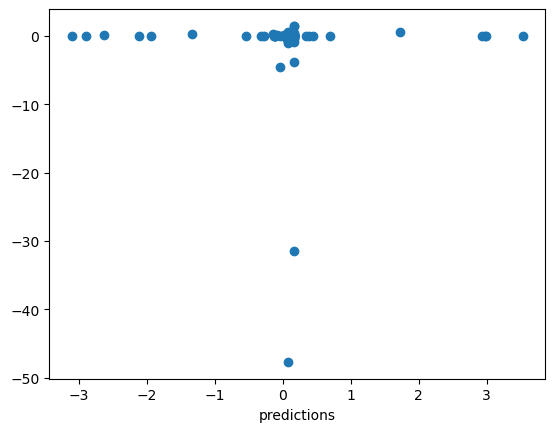

In [72]:
plt.scatter(best_preds_each[0], best_yset_each[0])
plt.xlabel("predictions")
plt.show()

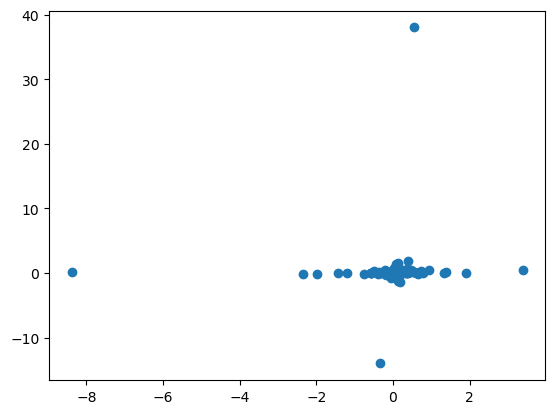

In [73]:
plt.scatter(best_preds_each[1], best_yset_each[1])
plt.show()

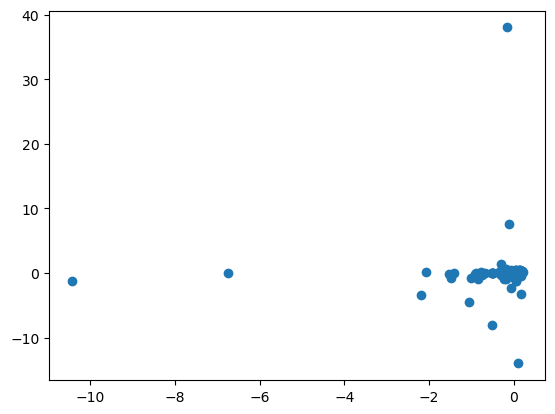

In [74]:
plt.scatter(best_preds_each[2], best_yset_each[2])
plt.show()

In [75]:
for i in best_mod_each:
    print(i)

[Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_state=3)
 Lasso(alpha=10.0, max_iter=1000000000, random_s

In [77]:
best_patt_each[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [ ]:
order = ['Lasso', "Ridge", 'RFR']

[(4.45171828414157, 'Lasso'), (375.9174512072165, 'RFR'), (757246.8060438645, 'Ridge')]


([0, 1, 2], [Text(0, 0, 'Lasso'), Text(1, 0, 'RFR'), Text(2, 0, 'Ridge')])

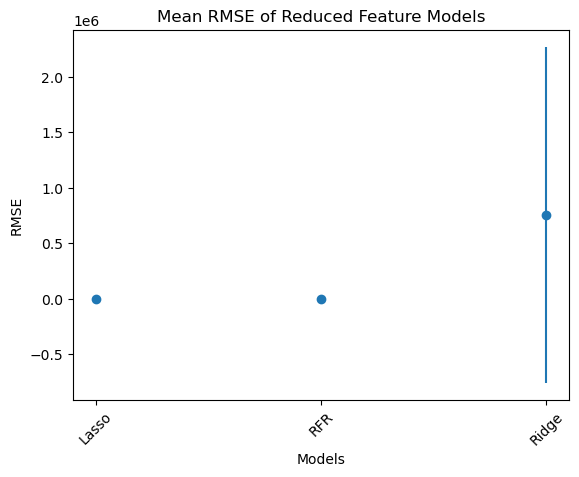

In [79]:
# Scores and plot

zipped = zip(all_mods_mean,order)
sorted_ls = sorted(zipped)

means, labels = zip(*sorted_ls)
print(sorted_ls)
my_order = [0,2,1]

all_mods_std_sorted = [all_mods_std[i] for i in my_order]
plt.errorbar(labels,means,yerr = all_mods_std_sorted, fmt ='o')
plt.ylabel("RMSE")
plt.xlabel("Models")
plt.title("Mean RMSE of Reduced Feature Models")
plt.xticks(rotation=45)

In [81]:
# Lasso: Trying to obtain coefficient weights, inconclusive due to reduced features model. 

with open("red_feat_scores", "rb") as file:

    scores = pickle.load(file) 

with open("red_feat_predictions", "rb") as file:

    preds = pickle.load(file) 

with open("red_feat_y_tests", "rb") as file:

    y_tests = pickle.load(file) 

print(np.array(y_tests[2]))

lasso_scores = scores[1]
lasso_preds = predictions[1]
#print(lasso_preds)

# for i in lasso_preds[1]:
#     print(len(i))
#     print(i)

y_preds = []
for i in lasso_preds[1][0]:
    y_preds.append(i[0])

print(np.array(y_preds))
print(len(y_preds))


min_score = min(lasso_scores)
best_ind = lasso_scores.index(min_score)



#print(len(y_tests[2][0:295,:]) == len(y_test)) # size should be the same
plt.scatter(np.array( np.array(y_preds)),y_tests[2][1:296])
plt.ylabel("y_test")
plt.xlabel("y_preds")
plt.title("Lasso: y_test vs. y_preds")
plt.show()

# plt.hist(y_test, label = 'y_test')
# plt.hist(y_pred, label = 'y_pred')
# plt.show()


[ 1.200e-01  1.200e-01  9.000e-02  1.600e-01  1.000e-14  3.400e-01
  5.100e-01  1.000e-02  2.000e-02  1.000e-14 -1.000e-02  3.300e-01
  2.400e-01  1.700e-01  8.000e-02  3.000e-02  2.000e-02  3.000e-02
  2.000e-02  1.000e-14  1.000e-14  1.000e-14  1.000e-14  7.000e-02
  7.000e-02  7.000e-02  7.000e-02  3.200e-01  3.300e-01  1.590e+00
  3.200e-01  1.000e-02  2.000e-02  2.000e-02  1.000e-02  2.000e-01
  5.000e-02  4.000e-02  5.000e-02  1.900e-01  5.000e-01  1.300e-01
  1.000e-14 -2.200e-01 -5.000e-02 -1.500e-01  1.000e-01  1.200e-01
  1.600e-01  1.100e-01  1.600e-01  1.000e-14  1.000e-14  1.000e-14
  1.000e-14  9.000e-02  8.000e-02  2.000e-02  8.000e-02  1.000e-14
  1.000e-14  1.000e-14  1.000e-14  1.000e-14  1.000e-14  1.300e-01
  2.000e-02  1.200e-01  1.500e-01  9.000e-02  7.000e-02  9.000e-02
  9.000e-02  6.000e-02  7.900e-01  8.200e-01  7.800e-01  7.800e-01
  8.000e-02  1.100e-01  1.900e-01  2.000e-02  2.000e-02  1.100e-01
 -1.000e-02  1.600e-01  1.100e-01 -1.200e-01  1.000e-14  1.000

TypeError: 'numpy.float64' object is not iterable

In [82]:
# Ridge, same situation as Lasso
ridge_scores = scores[1]
ridge_preds = predictions[1]
ridge_ytests = y_tests[1]

min_score = min(ridge_scores)
best_ind = ridge_scores.index(min_score)

y_pred = ridge_preds[best_ind] #watch out, could be a double array
y_test = ridge_ytests[best_ind]

print(len(y_pred) == len(y_test)) # size should be the same
plt.plot(y_test, y_pred)
plt.show()

plt.hist(y_test, label = 'y_test')
plt.hist(y_pred, label = 'y_pred')
plt.show()

KeyError: 2

In [83]:
# RFRegressor, same situation as Lasso
rfr_scores = scores[2]
rfr_preds = predictions[2]
rfr_ytests = y_tests[2]

min_score = min(rfr_scores)
best_ind = rfr_scores.index(min_score)

y_pred = rfr_preds[best_ind] #watch out, could be a double array
y_test = rfr_ytests[best_ind]

print(len(y_pred) == len(y_test)) # size should be the same
plt.plot(y_test, y_pred)
plt.show()

plt.hist(y_test, label = 'y_test')
plt.hist(y_pred, label = 'y_pred')
plt.show()

KeyError: 3

## XGBoost (No Reduced Features) Pipeline

In [84]:
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def MLpipe_xgboost_RMSE(X, y, preprocessor, ML_algo, param_grid, grps):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.

    You should:

    1. Loop through 10 different random states
    2. Split your data 
    3. Fit a model using GridSearchCV with KFold and the predefined Preprocessor 
    4. Calculate the model's error on the test set 
    5. Return a list of 10 test scores and 10 best models 
    '''
    def rmse(predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())
    
    #use make_scorer to minimize RMSE
    rmse_scor = make_scorer(rmse, greater_is_better=False)

    # lists to be returned 
    test_scores = []
    best_models = []
    
    avg_test = []
    ret_patts = []

    # your code here...

    pred_results = []

    prepro = Pipeline(steps=[('preprocessor', preprocessor)])

    rand_states = range(10,15) 

    #reset the indices of X and y bc they are originally indexed by Num
    X = X.reset_index(drop = True)
    y = y.reset_index(drop = True)

    y_test_sets = []
    X_test_sets = []


    for i in rand_states: # for 10 random states, 10 random shuffles
        print("random state:", i)
        #first split: test & other
        gss = GroupShuffleSplit(n_splits = 1, test_size = 0.2) # 1 split makes GroupTimeSeriesSplit equivalent to train_test_split?

        X_other, y_other, groups_other = [], [], []
        X_test, y_test = [], []

        for other_idx, test_idx in gss.split(X, y, grps):
            #print("OTHER:", other_idx, "TEST:", test_idx)
            #print("groups in other", grps.iloc[other_idx], "groups in test:", grps.iloc[test_idx])
            print("\t Other size:", len(other_idx)/X.shape[0], "Test size:", len(test_idx)/X.shape[0])
            X_other, y_other, groups_other = X.iloc[other_idx], y.iloc[other_idx], groups.iloc[other_idx]
            X_test, y_test, groups_test = X.iloc[test_idx], y.iloc[test_idx], groups.iloc[test_idx]
        y_test_sets.append(y_test)
        X_test_sets.append(X_test)

        # Preprocess
        # Preprocessing converts 2D DF into 2D numpy array
        X_other = prepro.fit_transform(X_other) 
        feature_names = preprocessor.get_feature_names_out()
        X_test = prepro.transform(X_test)

        # Convert X_other and X_test to df to use iloc, X_test later
        X_other = pd.DataFrame(data = X_other, columns = feature_names, index=y_other.index)


        print("After Preprocessing, X_other shape:",X_other.shape)


        #Second split: train and val sets
        gtss_cv = GroupKFold(n_splits=4) #4 splits

        X_train, y_train, groups_train = [], [], []
        X_val, y_val, groups_val = [], [], []

        
        test_scores_split = [] # and get a set of scores
        # choose the model set of models (indexed on patterns) between all 4 splits

        patterns = [] #len == 4
        patt_models = [] # len == 4
        split_y_preds = []
        split_models = []


        #will iterate 4 times for each fold
        count = 1
        for train_idx, val_idx in gtss_cv.split(X= X_other, y=y_other, groups = groups_other):
            
            print("fold:", count)

            # print("TRAIN:", train_idx, "Val:", val_idx)
            # print("\t Train size %:", len(train_idx)/X.shape[0], "Val size %:", len(val_idx)/X.shape[0])
            # print("\t Train size:", len(train_idx), "Val size %:", len(val_idx),"Test size %:", len(test_idx))

            # SPLIT 2
            X_train, y_train, groups_train = X_other.iloc[train_idx], y_other.iloc[train_idx], groups_other.iloc[train_idx]
            X_val, y_val, groups_val = X_other.iloc[val_idx], y_other.iloc[val_idx], groups_other.iloc[val_idx]

            X_train_df = pd.DataFrame(data = X_train.values, columns = feature_names, index=y_train.index)
            X_val_df = pd.DataFrame(data = X_val.values, columns = feature_names, index=y_val.index)
            X_test_df = pd.DataFrame(data = X_test, columns = feature_names, index=y_test.index)


            # create xgboost model and set parameters 
            ml = ML_algo
            pg = ParameterGrid(param_grid)
            scores = np.zeros(len(pg))

            # FINDING THE BEST PARAMETERS FOR A GIVEN PATTERN
            for i in range(len(pg)):
                params = pg[i]
                ml.set_params(**params)

                ml.fit(X_train_df, y_train, eval_set=[(X_val_df, y_val)], verbose = False)
                y_val_pred = ml.predict(X_val_df)
                scores[i] = np.sqrt(mean_squared_error(y_val, y_val_pred))


            best_params = np.array(pg)[scores == np.min(scores)]
            
            ml.set_params(**best_params[0])

            # fit model to train data 
            ml.fit(X_train_df,y_train,eval_set=[(X_val_df, y_val)], verbose=False)
            split_models.append(ml)


            # predict on validation 
            y_CV_pred = ml.predict(X_val_df)
            print('the CV RMSE:',np.sqrt(mean_squared_error(y_val,y_CV_pred)))

            # predict on test 
            split_y_preds.append
            y_test_pred = ml.predict(X_test_df)
            split_y_preds.append(y_test_pred)
            print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
            print('the test R2:',r2_score(y_test,y_test_pred))

            test_scores_split.append(np.sqrt(mean_squared_error(y_test,y_test_pred)))
            
            count += 1
        
        avg_test_folds = np.mean(test_scores_split)
        print(f'overall test mean for splits: {avg_test_folds}')
        print(f'overall test std for splits: {np.std(test_scores_split)}\n')
        avg_test.append(avg_test_folds)
        
    
        best_preds = np.array(split_y_preds)[test_scores_split == np.min(test_scores_split)]
        best_model = np.array(split_models)[test_scores_split == np.min(test_scores_split)]

        pred_results.append(best_preds)
        best_models.append(best_model) # best set of models (for each pattern)
        test_scores.append(np.min(test_scores_split)) # best fold score
        #ret_patts.append(best_patterns) # best patterns (best_patterns should be the same length as best_patt_models)
    #should be 10
    print('length of test scores', len(test_scores))
    print('length of best models', len(best_models))
    print('length of avg scores over 4 folds', len(avg_test)) 

    print('length of pred results', len(pred_results))
    print('length of X tests', len(X_test_sets), "length of y tests",len(y_test_sets))



    return test_scores, best_models, avg_test, pred_results, y_test_sets, X_test_sets



In [85]:
param_grid = {"learning_rate": [0.03],
  "n_estimators": [10000],
  "seed": [0],
  "min_child_weight": [6,8,10,12],
  "gamma": [0, 0.01, 0.1, 1, 10, 100],
  "max_depth": [1, 2, 3, 10, 30],
  'tree_method' : ['hist'],
  "missing": [np.nan], 
  "colsample_bytree": [0.9],              
  "subsample": [0.66]}


import time

start_time = time.time()
model = xgboost.XGBRegressor(early_stopping_rounds=50)

best_test_scores, best_models, avg_test_folds, pred_results, y_tests, X_tests = MLpipe_xgboost_RMSE(f_mat, tar, preprocessor,model,param_grid, groups )
print('XGBoost reduced features model running time:', time.time()-start_time)





random state: 10
	 Other size: 0.796916890080429 Test size: 0.20308310991957104
After Preprocessing, X_other shape: (1189, 91)
fold: 1
the CV RMSE: 2.46640502747736
the test RMSE: 1559.835843554607
the test R2: -0.004171040970043283
fold: 2
the CV RMSE: 5.224592883204601
the test RMSE: 1559.332057191618
the test R2: -0.003522503517380704
fold: 3
the CV RMSE: 148.87076834409314
the test RMSE: 1559.2162763857443
the test R2: -0.003373485442474067
fold: 4
the CV RMSE: 2.58742365748636
the test RMSE: 1559.9607776653372
the test R2: -0.004331904359191618
overall test mean for splits: 1559.5862386993267
overall test std for splits: 0.3178295034967484

random state: 11
	 Other size: 0.7949061662198391 Test size: 0.20509383378016086
After Preprocessing, X_other shape: (1186, 89)
fold: 1
the CV RMSE: 23.152363301974816
the test RMSE: 45.88956732369324
the test R2: -51.03316547946045
fold: 2
the CV RMSE: 1575.0498445096719
the test RMSE: 7.667320420232462
the test R2: -0.4525782849665534
fold: 3

In [87]:

print("scores",len(best_test_scores), best_test_scores)
print("models",len(best_models),best_models)

print("avg_fold_scores",len(avg_test_folds), avg_test_folds)

print("predictions",len(pred_results), len(pred_results[0]))
print("y_tests_all",len(y_tests), len(y_tests[0]), y_tests)
print("X_tests_all",len(X_tests), len(X_tests[0]), X_tests)

#best_models

scores 5 [1559.2162763857443, 7.667320420232462, 3.500679405058419, 147.19499018423465, 4.390457407722734]
models 5 [array([XGBRegressor(base_score=None, booster=None, callbacks=None,
                    colsample_bylevel=None, colsample_bynode=None,
                    colsample_bytree=0.9, device=None, early_stopping_rounds=50,
                    enable_categorical=False, eval_metric=None, feature_types=None,
                    gamma=0, grow_policy=None, importance_type=None,
                    interaction_constraints=None, learning_rate=0.03, max_bin=None,
                    max_cat_threshold=None, max_cat_to_onehot=None,
                    max_delta_step=None, max_depth=1, max_leaves=None,
                    min_child_weight=6, missing=nan, monotone_constraints=None,
                    multi_strategy=None, n_estimators=10000, n_jobs=None,
                    num_parallel_tree=None, random_state=None, ...)                ],
      dtype=object), array([XGBRegressor(base_score=

In [ ]:
# Pickle to save results
# saves_str  =['best_test_scores', 'best_models', 'avg_test_folds',  'pred_results', 'y_tests', 'X_tests' ]
# saves =[best_test_scores, best_models, avg_test_folds, pred_results, y_tests, X_tests]
# for i in range(len(saves_str)):
#     str = "xgb_%s" % saves_str[i]
#     with open(str, 'wb') as f:
#         pickle.dump(saves[i], f)


In [88]:
all_mods_mean

[4.45171828414157, 757246.8060438645, 375.9174512072165]

In [90]:
all_mod_labels = order

In [91]:
all_mods_std

[0.65046810550929, 1514484.4405954995, 602.8500996060196]

In [92]:
xgb_mean_sc = np.mean(best_test_scores)
xgb_std = np.std(best_test_scores)

[4.45171828414157, 757246.8060438645, 375.9174512072165, 344.3939447605986]
[0.65046810550929, 1514484.4405954995, 602.8500996060196, 609.8977183786974]
[(4.45171828414157, 'Lasso'), (344.3939447605986, 'XGBoost'), (375.9174512072165, 'RFR'), (757246.8060438645, 'Ridge')]
(4.45171828414157, 344.3939447605986, 375.9174512072165, 757246.8060438645)
('Lasso', 'XGBoost', 'RFR', 'Ridge')
[0.65046810550929, 609.8977183786974, 602.8500996060196, 1514484.4405954995]


([0, 1, 2, 3],
 [Text(0, 0, 'Lasso'),
  Text(1, 0, 'XGBoost'),
  Text(2, 0, 'RFR'),
  Text(3, 0, 'Ridge')])

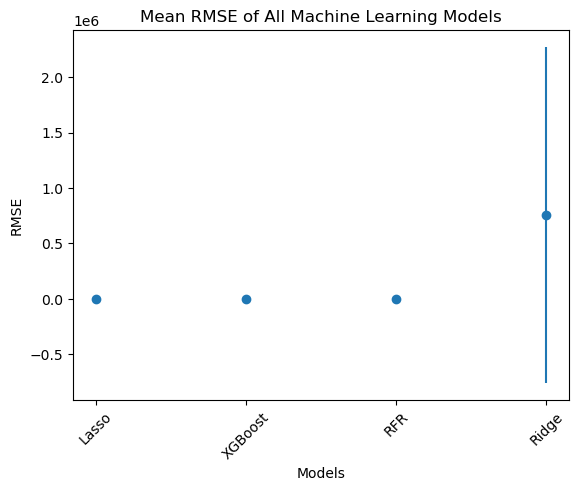

In [94]:
#Score Evaluation of all Four models
xgb_mean_sc = np.mean(best_test_scores)
xgb_std = np.std(best_test_scores)

# all_mods_mean = [777996.6289210842, 2.7150278976898905, 3.124562932560574]
# all_mod_labels = ['XGB', 'L2 (Ridge)', 'L1 (Lasso)', "RFR"]
# all_mods_std = [1555914.9786355665, 2.006929134172715, 2.222202878852668]

all_mod_labels = all_mod_labels + ['XGBoost']
all_mods_mean_xgb = all_mods_mean + [xgb_mean_sc]
all_mods_std_xgb = all_mods_std + [xgb_std]

print(all_mods_mean_xgb)
print(all_mods_std_xgb)


zipped = zip(all_mods_mean_xgb,all_mod_labels)

sorted_ls = sorted(zipped)
print(sorted_ls)

means, labels = zip(*sorted_ls)

print(means)
print(labels)

li = [0,3,2,1]
all_mods_std_xgb_sort = [all_mods_std_xgb[i] for i in li]
print(all_mods_std_xgb_sort)

plt.errorbar(labels,means,yerr = all_mods_std_xgb_sort, fmt ='o')
plt.ylabel("RMSE")
plt.xlabel("Models")
plt.title("Mean RMSE of All Machine Learning Models")
plt.savefig("../figures/allmlmeans")
plt.xticks(rotation=45)

In [95]:
all_mods_std_xgb_sort

[0.65046810550929, 609.8977183786974, 602.8500996060196, 1514484.4405954995]

In [96]:
#Standard deviation compared to baseline for mean test RMSEs for each model
sum = 0
for i in all_mods_std_xgb_sort:
    sum += ((i - base_score)**2)/len(all_mods_std_xgb_sort)

std = np.sqrt(sum)
print(sum)

572954811786.718


In [97]:
best_scrs = [2.392, 2.538, 3.022,3.365]

print(np.std(best_scrs))



0.3873611848133472


(4.45171828414157, 344.3939447605986, 375.9174512072165)
('Lasso', 'XGBoost', 'RFR')
[0.65046810550929, 609.8977183786974, 602.8500996060196]


([0, 1, 2], [Text(0, 0, 'Lasso'), Text(1, 0, 'XGBoost'), Text(2, 0, 'RFR')])

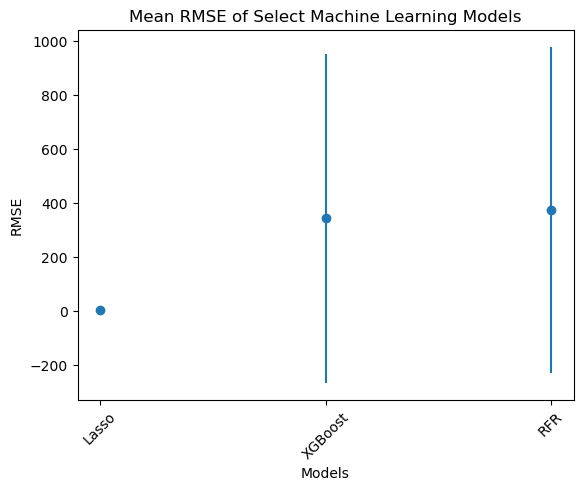

In [99]:
# Better scaled plot for means and STDs
means_scaled = means[0:3]
print(means_scaled)
labels_scaled = labels[0:3]
print(labels_scaled)
std_scaled_fr = all_mods_std_xgb_sort[0:3]
print(std_scaled_fr)

plt.errorbar(labels_scaled,means_scaled,yerr = std_scaled_fr, fmt ='o')
plt.ylabel("RMSE")
plt.xlabel("Models")
plt.title("Mean RMSE of Select Machine Learning Models")
plt.savefig("../figures/allmlmeans_scaled")
plt.xticks(rotation=45)

In [100]:
xgb_min = min(best_test_scores)
best_ind = best_test_scores.index(xgb_min)


In [101]:
XGB = best_models[best_ind][0]
print(xgb_min)

3.500679405058419


In [102]:
print(XGB.get_xgb_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'device': None, 'eval_metric': None, 'gamma': 0, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.03, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 1, 'max_leaves': None, 'min_child_weight': 6, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.66, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None, 'seed': 0}


# Evaluation

We will use XGBoost feature importance measured by weight (how many times a feature is selected across mutliple models) and total_gain for global values, as well as SHAP values.


For local feature importance, we will use SHAP values.


In [104]:
# Examining global feature importance for Lasso. We can see that examining the coefficient matrix is complex.
with open("red_feat_models", "rb") as file:
    models = pickle.load(file) 
print(len(models))
lasso_models = models[1]
print(lasso_models[0][0][0])
coeff = np.zeros(lasso_models[0][0][0].sparse_coef_.shape[1])
print(lasso_models[0][0][0].sparse_coef_.values)

for mod in lasso_models[0][0]:
    
    #print(mod.coef_)
    coeff += mod.sparse_coef_

coeff_avg = coeff/len(lasso_models[0][0])

print(coeff_avg)


3
Lasso(alpha=0.06309573444801933, max_iter=10000, random_state=3, tol=0.01)


AttributeError: 'csr_matrix' object has no attribute 'values'

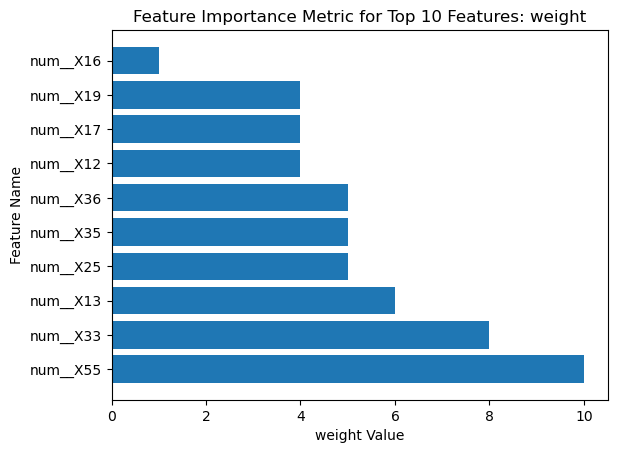

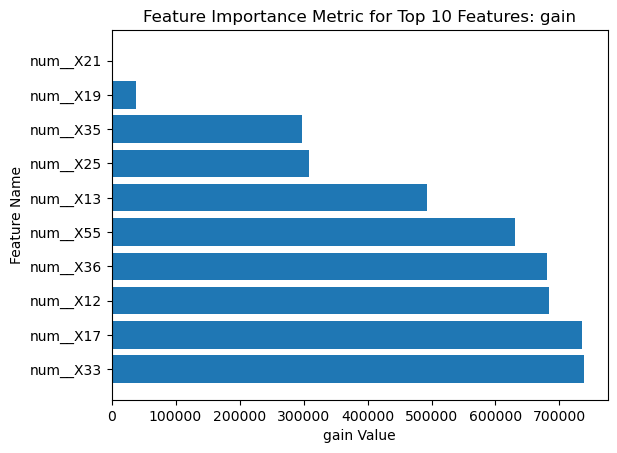

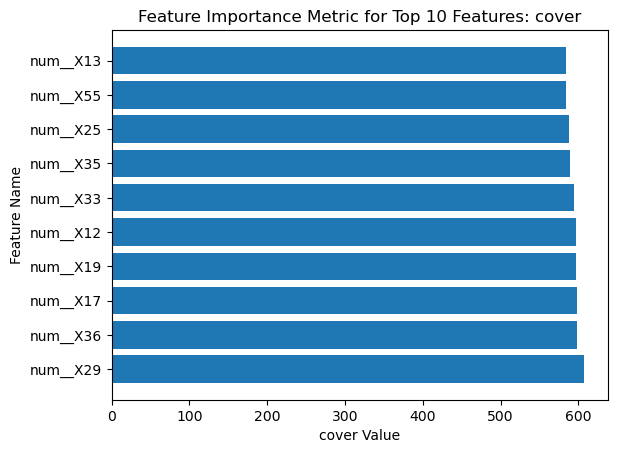

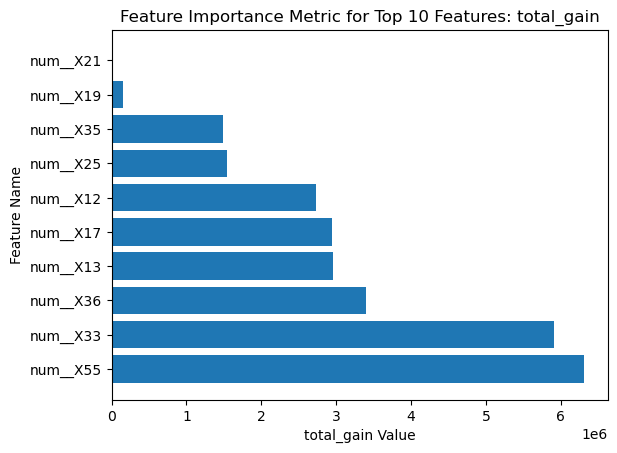

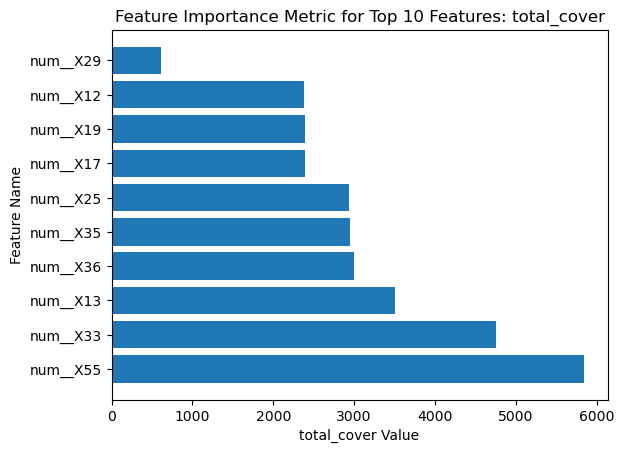

In [106]:
# Global XGB eval metrics:
# from itertools import take
importance_types = ["weight", "gain", "cover", "total_gain", "total_cover"]

# scores = XGB.get_booster().get_score(importance_type= "total_gain")
# scores_sorted = dict(sorted(scores.items(), key=lambda item: item[1], reverse = True))
# print(scores_sorted)
# print(scores_sorted.items())
# res = 



for i in importance_types:
    scores = XGB.get_booster().get_score(importance_type= i)
    scores_sorted = dict(sorted(scores.items(), key=lambda item: item[1], reverse = True))
    res = {key: scores_sorted[key] for key in __builtins__.list(scores_sorted)[:10]}
    y_pos = np.arange(len(res))
    plt.barh(y = res.keys(), width = res.values())
    #plt.yticks(res.keys())
    plt.title("Feature Importance Metric for Top 10 Features: %s" % i)
    plt.xlabel("%s Value" % i)
    plt.ylabel("Feature Name")
    plt.savefig("../figures/xgboostmetric_%s" % i)
    plt.show()

(294, 91)


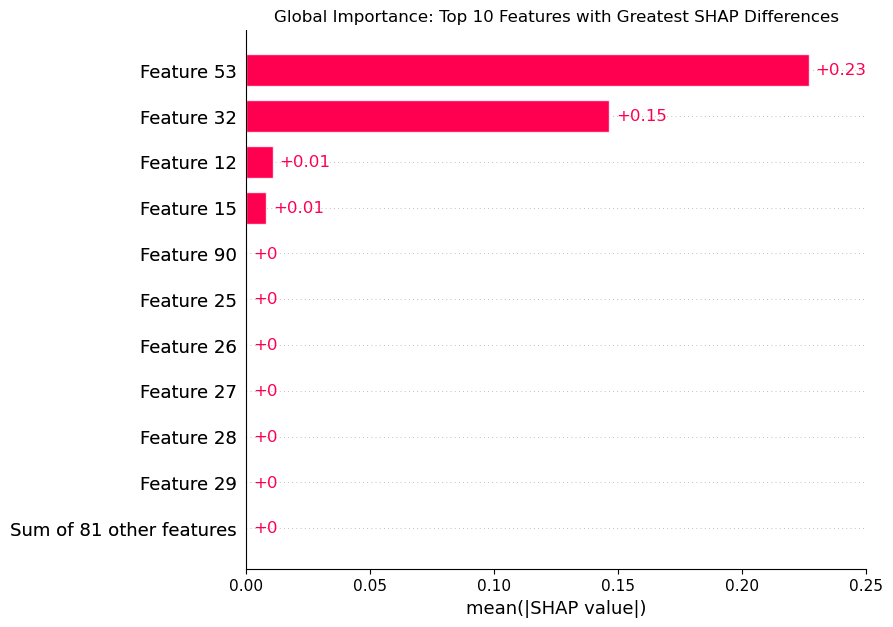

In [108]:
# Shap values

# Global:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model

explainer = shap.TreeExplainer(XGB)

X_test = X_tests[best_ind]

# transform the test set
X_test_transformed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
print(np.shape(X_test_transformed))
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns= feature_names, index=X_test.index)


explanation = explainer(X_test_transformed)
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed)



shap.plots.bar(explanation, max_display = 11, show=False )
plt.title("Global Importance: Top 10 Features with Greatest SHAP Differences")
plt.savefig("../figures/globalshapvals")
#fig, ax = plt.gcf(), plt.gca()
plt.show()

In [109]:
X_test.iloc[175]

Country    Poland
X1            0.0
X2           0.35
X3           0.19
X4            1.7
            ...  
X79          1.26
X80          0.93
X81           0.0
X82           0.0
S               2
Name: 743, Length: 83, dtype: object

In [112]:
# Local SHAP comparison
# 
index = 80 # the index of the point to explain
print('Expected Value:', explainer.expected_value) 

#shap.force_plot( explainer.expected_value, shap_values[index,:], features = X_test_transformed[index, :],feature_names = feature_names,matplotlib= True, show = False).savefig('data_0.png')
shap.force_plot( explainer.expected_value, shap_values[index,:], features = X_test_transformed[index, :],feature_names = feature_names,matplotlib= True, show = False)
plt.savefig("../figures/localshap_%s" % index)

Expected Value: 2.7006593


In [113]:
index = 1 # the index of the point to explain
print('Expected Value:', explainer.expected_value) 

#shap.force_plot( explainer.expected_value, shap_values[index,:], features = X_test_transformed[index, :],feature_names = feature_names,matplotlib= True, show = False).savefig('data_0.png')
shap.force_plot( explainer.expected_value, shap_values[index,:], features = X_test_transformed[index, :],feature_names = feature_names,matplotlib= True, show = False)
#print( shap_values[index,:])
plt.savefig("../figures/localshap_%s" % index)
# print( sorted(shap_values[index,:]))

#1,9, 29


Expected Value: 2.7006593


In [115]:
index = 9 # the index of the point to explain
print('Expected Value:', explainer.expected_value) 

#shap.force_plot( explainer.expected_value, shap_values[index,:], features = X_test_transformed[index, :],feature_names = feature_names,matplotlib= True, show = False).savefig('data_0.png')
shap.force_plot( explainer.expected_value, shap_values[index,:], features = X_test_transformed[index, :],feature_names = feature_names,matplotlib= True, show = False)
#print( shap_values[index,:])
plt.savefig("../figures/localshap_%s" % index)
# print( sorted(shap_values[index,:]))


Expected Value: 2.7006593


In [117]:
index = 29 # the index of the point to explain
print('Expected Value:', explainer.expected_value) 

#shap.force_plot( explainer.expected_value, shap_values[index,:], features = X_test_transformed[index, :],feature_names = feature_names,matplotlib= True, show = False).savefig('data_0.png')
shap.force_plot( explainer.expected_value, shap_values[index,:], features = X_test_transformed[index, :],feature_names = feature_names,matplotlib= True, show = False)
# print( sorted(shap_values[index,:]))
plt.savefig("../figures/localshap_%s" % index)

Expected Value: 2.7006593


In [118]:
index = 220 # the index of the point to explain
print('Expected Value:', explainer.expected_value) 

#shap.force_plot( explainer.expected_value, shap_values[index,:], features = X_test_transformed[index, :],feature_names = feature_names,matplotlib= True, show = False).savefig('data_0.png')
shap.force_plot( explainer.expected_value, shap_values[index,:], features = X_test_transformed[index, :],feature_names = feature_names,matplotlib= True, show = False)
plt.savefig("../figures/localshap_%s" % index)

Expected Value: 2.7006593


In [119]:
index = 175 # the index of the point to explain
print('Expected Value:', explainer.expected_value) 

shap.force_plot( explainer.expected_value, shap_values[index,:], features = X_test_transformed[index, :],feature_names = feature_names, matplotlib= True,show = False)
print( sorted(shap_values[index,:]))
plt.savefig("../figures/localshap_%s" % index)

Expected Value: 2.7006593
[-0.116973154, -0.10987338, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0050133076, 0.0062403753]


In [120]:
index = 260 # the index of the point to explain
print('Expected Value:', explainer.expected_value) 

fig = shap.force_plot( explainer.expected_value, shap_values[index,:], features = X_test_transformed[index, :],feature_names = feature_names,matplotlib= True,show = False).savefig('data_250.png')
plt.savefig("../figures/localshap_%s" % index)

Expected Value: 2.7006593
